# Preparation of the data for the prediction models
In this notebook, the necessary datasets for the elaboration of the prediction models will be joined. These are based on the accumulated data of:

**Solar radiation of the day before the call** https://opendata.aemet.es/centrodedescargas/productosAEMET<br>
**Solar radiation of two days before the day of data collection** http://www.soda-pro.com/web-services/radiation/cams-radiation-service<br>
**Climate data of the five days prior to the call** https://openweathermap.org/api/one-call-api#history<br>
**Weather forecast of the two days following the call** https://openweathermap.org/api/one-call-api<br>


- [Preparation](#Preparation)<br>

### 1. [Historical weather data preparation](#Historical-weather-data-preparation)

### 2. [Preparation of weather predictions](#Preparation-of-weather-predictions)

### 3. [Preparation of radiation data from the previous day](#Preparation-of-radiation-data-from-the-previous-day)

### 4. [Preparation of historical radiation data](#Preparation-of-historical-radiation-data)

### 5. [Join of datasets](#Join-of-datasets)

### 6. [Final function](#Final-function)


## Previous note
In order to run the script properly, use the following command line to open the notebook from the terminal:

In [2]:
#jupyter-lab --NotebookApp.iopub_data_rate_limit=1.0e15

**CAUTION:** Takes hours to run

### Preparation

In [3]:
import pandas as pd
import numpy as np
import random
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None
pd.options.display.max_rows = None
hora_ini = 4
hora_fin = 20

The working directory is set

In [4]:
%cd /home/dsc/git/TFM/

/home/dsc/git/TFM


In [5]:
directorio = '/home/dsc/git/TFM/'

### ``distancia()``

Function that calculates the Euclidean or Manhattan distance between two points

In [6]:
import math 

def distancia(lat1, lon1, lat2, lon2, distancia = "euclidea"):
    
    if(distancia == "euclidea"):
        dist = math.sqrt((lat1 - lat2)**2 + (lon1 -lon2)**2)
    
    elif(distancia == "manhattan"):
        dist = abs(lat1 - lat2) + abs(lon1 -lon2)
  
    return dist 

### ``conversor_coordenadas()``

Function that transforms coordinates from GMS to decimal

In [7]:
def conversor_coordenadas(coord):
    # If coord is latitude, north of the equator is always positive
    # If coord is longitude, west of the Meridian 0º are negative
    
    D = int(coord[0:2])
    M = float(coord[2:4])
    S = float(coord[4:6])
    
    #GMS to GD
    DD = float((D) + (M/60) + (S/3600))
        
    if(coord[6] == "S" or coord[6] == "W"):
            DD = -DD
            
    return DD

# Historical weather data preparation
<div style = "float:right"><a style="text-decoration:none" href = "#Preparation-of-the-data-for-the-prediction-models">

The historical weather dataset where each row corresponds to the observation of each hour of each day (without the final processing) is imported. 

In [8]:
df_clima = pd.read_csv('./data/Historicos/historicos_climaticos_clean.csv', sep=',')

df_clima.head()

,date,hour,fecha_prediccion,estacion,temp,feels_like,pressure,humidity,dew_point,clouds,visibility,wind_speed,wind_deg,wind_gust,we
0,2021-04-04,4,2021-04-05,0252D,284.30,282.56,1014,93,283.21,0,10000.0,2.57,280,4.689019,800
1,2021-04-04,5,2021-04-05,0252D,284.59,282.57,1014,93,283.50,0,10000.0,3.09,290,4.689019,800
2,2021-04-04,6,2021-04-05,0252D,284.41,283.88,1015,87,282.33,0,10000.0,0.51,0,4.689019,800
3,2021-04-04,7,2021-04-05,0252D,284.99,284.61,1016,87,282.90,0,10000.0,0.51,0,4.689019,800
4,2021-04-04,8,2021-04-05,0252D,286.41,286.17,1016,82,283.41,0,10000.0,0.51,0,4.689019,800


In [9]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1870432 entries, 0 to 1870431
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   hour              int64  
 2   fecha_prediccion  object 
 3   estacion          object 
 4   temp              float64
 5   feels_like        float64
 6   pressure          int64  
 7   humidity          int64  
 8   dew_point         float64
 9   clouds            int64  
 10  visibility        float64
 11  wind_speed        float64
 12  wind_deg          int64  
 13  wind_gust         float64
 14  we                int64  
dtypes: float64(6), int64(6), object(3)
memory usage: 214.1+ MB


It is observed that most days have specific percentages of sky covered by clouds

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


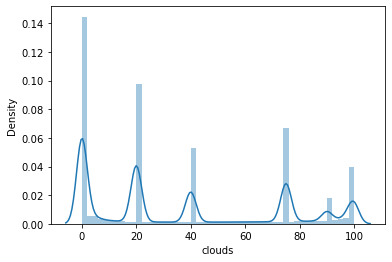

In [10]:
sns.distplot(df_clima["clouds"]);

It can be verified that the average temperature is centered between 275 and 300 Kº (2-27 ºC), reasonable values

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


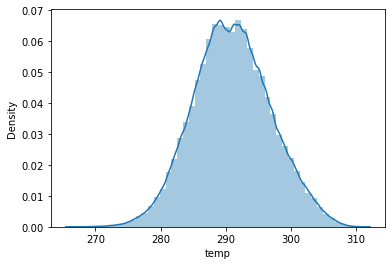

In [10]:
sns.distplot(df_clima["temp"]);

It can be verified that the average wind speed is 3.5 m / s, reasonable values

In [11]:
np.mean(df_clima["wind_speed"])

3.509140808098515

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


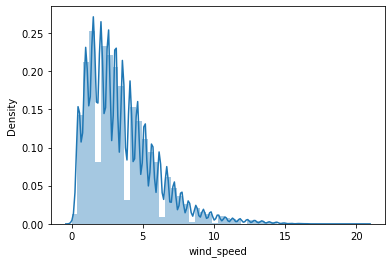

In [12]:
sns.distplot(df_clima["wind_speed"]);

It can be seen that the weather ID contains clear peaks in singular values. For example, 800 means clear sky

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


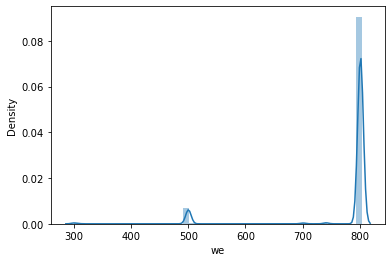

In [13]:
sns.distplot(df_clima["we"]);

It can be seen that there is no clear correlation between the type of weather and the average temperature of a day

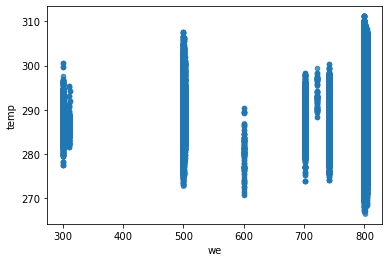

In [14]:
var1 = "we"
var2 = "temp"
data = pd.concat([df_clima[var2], df_clima[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

It can be verified that there is a positive correlation between the thermal sensation and the average temperature of a day

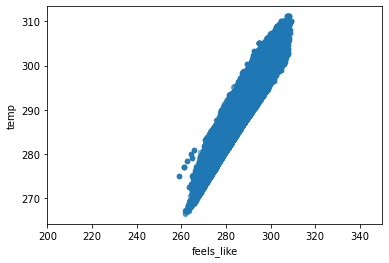

In [15]:
var1 = "feels_like"
var2 = "temp"
data = pd.concat([df_clima[var2], df_clima[var1]], axis = 1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5).axis(xmin = 200, xmax = 350);

There isn't a clear correlation between the average wind speed of a day and the average temperature of it

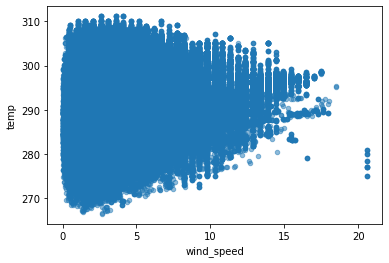

In [16]:
var1 = "wind_speed"
var2 = "temp"
data = pd.concat([df_clima[var2], df_clima[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

The historical weather dataset is imported with the final processing (where each row corresponds to the observations of the same hour for each of the 5 days prior to the download day)

In [17]:
df_clima = pd.read_csv('./data/Historicos/clima_por_horas.csv', sep=',')

df_clima.head()

,hour,fecha_prediccion,estacion,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,4,2021-04-05,0252D,284.30,282.56,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,285.17,283.96,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,284.75,282.73,1014,76,280.67,0,10000.0,2.06,290,4.689019,800,282.28,280.06,1020,75,278.09,0,10000.0,1.54,310,4.689019,800,284.67,282.93,1026,68,278.98,42,9767.26843,1.12,338,1.18,802
1,5,2021-04-05,0252D,284.59,282.57,1014,93,283.50,0,10000.0,3.09,290,4.689019,800,284.66,283.21,1012,81,281.52,0,10000.0,1.54,320,4.689019,800,283.71,282.39,1014,81,280.59,0,10000.0,1.03,0,4.689019,800,281.30,279.00,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,284.59,282.86,1026,67,278.69,50,9767.26843,1.02,336,1.10,800
2,6,2021-04-05,0252D,284.41,283.88,1015,87,282.33,0,10000.0,0.51,0,4.689019,800,285.18,284.34,1012,76,281.09,0,10000.0,0.51,0,4.689019,800,285.04,283.22,1014,71,279.96,0,10000.0,1.54,300,4.689019,800,281.42,279.47,1020,87,279.39,0,10000.0,1.54,280,4.689019,800,284.61,282.96,1026,68,278.92,41,9767.26843,0.97,324,1.07,802
3,7,2021-04-05,0252D,284.99,284.61,1016,87,282.90,0,10000.0,0.51,0,4.689019,800,287.22,286.25,1012,71,282.05,0,10000.0,1.03,0,4.689019,800,285.78,283.43,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,284.12,282.78,1021,70,278.87,0,10000.0,0.51,0,4.689019,800,286.04,284.80,1026,64,279.40,47,9767.26843,0.54,329,0.85,802
4,8,2021-04-05,0252D,286.41,286.17,1016,82,283.41,0,10000.0,0.51,0,4.689019,800,288.86,287.74,1013,55,279.85,0,10000.0,0.51,0,4.689019,800,288.53,287.51,1015,58,280.32,0,10000.0,0.51,0,4.689019,800,286.82,285.25,1021,54,277.69,0,10000.0,0.51,150,4.689019,800,287.52,286.42,1026,58,279.37,54,9767.26843,0.32,121,0.67,803


A column is added with the date of the day after the one when the data was obtained, since this will be the day for which we want to predict the radiation based on it

In [18]:
import datetime
fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=1)).year), str((pd.to_datetime(f) + datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=1)).day).zfill(2)) for f in df_clima["fecha_prediccion"]]
df_clima.insert(0, "fecha_rad", fechas_atrasadas, True)
df_clima.head()

,fecha_rad,hour,fecha_prediccion,estacion,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,2021-04-06,4,2021-04-05,0252D,284.30,282.56,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,285.17,283.96,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,284.75,282.73,1014,76,280.67,0,10000.0,2.06,290,4.689019,800,282.28,280.06,1020,75,278.09,0,10000.0,1.54,310,4.689019,800,284.67,282.93,1026,68,278.98,42,9767.26843,1.12,338,1.18,802
1,2021-04-06,5,2021-04-05,0252D,284.59,282.57,1014,93,283.50,0,10000.0,3.09,290,4.689019,800,284.66,283.21,1012,81,281.52,0,10000.0,1.54,320,4.689019,800,283.71,282.39,1014,81,280.59,0,10000.0,1.03,0,4.689019,800,281.30,279.00,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,284.59,282.86,1026,67,278.69,50,9767.26843,1.02,336,1.10,800
2,2021-04-06,6,2021-04-05,0252D,284.41,283.88,1015,87,282.33,0,10000.0,0.51,0,4.689019,800,285.18,284.34,1012,76,281.09,0,10000.0,0.51,0,4.689019,800,285.04,283.22,1014,71,279.96,0,10000.0,1.54,300,4.689019,800,281.42,279.47,1020,87,279.39,0,10000.0,1.54,280,4.689019,800,284.61,282.96,1026,68,278.92,41,9767.26843,0.97,324,1.07,802
3,2021-04-06,7,2021-04-05,0252D,284.99,284.61,1016,87,282.90,0,10000.0,0.51,0,4.689019,800,287.22,286.25,1012,71,282.05,0,10000.0,1.03,0,4.689019,800,285.78,283.43,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,284.12,282.78,1021,70,278.87,0,10000.0,0.51,0,4.689019,800,286.04,284.80,1026,64,279.40,47,9767.26843,0.54,329,0.85,802
4,2021-04-06,8,2021-04-05,0252D,286.41,286.17,1016,82,283.41,0,10000.0,0.51,0,4.689019,800,288.86,287.74,1013,55,279.85,0,10000.0,0.51,0,4.689019,800,288.53,287.51,1015,58,280.32,0,10000.0,0.51,0,4.689019,800,286.82,285.25,1021,54,277.69,0,10000.0,0.51,150,4.689019,800,287.52,286.42,1026,58,279.37,54,9767.26843,0.32,121,0.67,803


The necessary columns are renamed

In [19]:
df_clima = df_clima.rename(index = str, columns = {"hour": "hora", "estacion": "indicativo"})
df_clima.head()

,fecha_rad,hora,fecha_prediccion,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,2021-04-06,4,2021-04-05,0252D,284.30,282.56,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,285.17,283.96,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,284.75,282.73,1014,76,280.67,0,10000.0,2.06,290,4.689019,800,282.28,280.06,1020,75,278.09,0,10000.0,1.54,310,4.689019,800,284.67,282.93,1026,68,278.98,42,9767.26843,1.12,338,1.18,802
1,2021-04-06,5,2021-04-05,0252D,284.59,282.57,1014,93,283.50,0,10000.0,3.09,290,4.689019,800,284.66,283.21,1012,81,281.52,0,10000.0,1.54,320,4.689019,800,283.71,282.39,1014,81,280.59,0,10000.0,1.03,0,4.689019,800,281.30,279.00,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,284.59,282.86,1026,67,278.69,50,9767.26843,1.02,336,1.10,800
2,2021-04-06,6,2021-04-05,0252D,284.41,283.88,1015,87,282.33,0,10000.0,0.51,0,4.689019,800,285.18,284.34,1012,76,281.09,0,10000.0,0.51,0,4.689019,800,285.04,283.22,1014,71,279.96,0,10000.0,1.54,300,4.689019,800,281.42,279.47,1020,87,279.39,0,10000.0,1.54,280,4.689019,800,284.61,282.96,1026,68,278.92,41,9767.26843,0.97,324,1.07,802
3,2021-04-06,7,2021-04-05,0252D,284.99,284.61,1016,87,282.90,0,10000.0,0.51,0,4.689019,800,287.22,286.25,1012,71,282.05,0,10000.0,1.03,0,4.689019,800,285.78,283.43,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,284.12,282.78,1021,70,278.87,0,10000.0,0.51,0,4.689019,800,286.04,284.80,1026,64,279.40,47,9767.26843,0.54,329,0.85,802
4,2021-04-06,8,2021-04-05,0252D,286.41,286.17,1016,82,283.41,0,10000.0,0.51,0,4.689019,800,288.86,287.74,1013,55,279.85,0,10000.0,0.51,0,4.689019,800,288.53,287.51,1015,58,280.32,0,10000.0,0.51,0,4.689019,800,286.82,285.25,1021,54,277.69,0,10000.0,0.51,150,4.689019,800,287.52,286.42,1026,58,279.37,54,9767.26843,0.32,121,0.67,803


Kelvin degrees are converted into Cº

In [20]:
df_clima["temp_d-1"] = df_clima["temp_d-1"] - 273.15
df_clima["temp_d-2"] = df_clima["temp_d-2"] - 273.15
df_clima["temp_d-3"] = df_clima["temp_d-3"] - 273.15
df_clima["temp_d-4"] = df_clima["temp_d-4"] - 273.15
df_clima["temp_d-5"] = df_clima["temp_d-5"] - 273.15

df_clima["feels_like_d-1"] = df_clima["feels_like_d-1"] - 273.15
df_clima["feels_like_d-2"] = df_clima["feels_like_d-2"] - 273.15
df_clima["feels_like_d-3"] = df_clima["feels_like_d-3"] - 273.15
df_clima["feels_like_d-4"] = df_clima["feels_like_d-4"] - 273.15
df_clima["feels_like_d-5"] = df_clima["feels_like_d-5"] - 273.15

df_clima.head()

,fecha_rad,hora,fecha_prediccion,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,2021-04-06,4,2021-04-05,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.689019,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.689019,800,11.52,9.78,1026,68,278.98,42,9767.26843,1.12,338,1.18,802
1,2021-04-06,5,2021-04-05,0252D,11.44,9.42,1014,93,283.50,0,10000.0,3.09,290,4.689019,800,11.51,10.06,1012,81,281.52,0,10000.0,1.54,320,4.689019,800,10.56,9.24,1014,81,280.59,0,10000.0,1.03,0,4.689019,800,8.15,5.85,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,11.44,9.71,1026,67,278.69,50,9767.26843,1.02,336,1.10,800
2,2021-04-06,6,2021-04-05,0252D,11.26,10.73,1015,87,282.33,0,10000.0,0.51,0,4.689019,800,12.03,11.19,1012,76,281.09,0,10000.0,0.51,0,4.689019,800,11.89,10.07,1014,71,279.96,0,10000.0,1.54,300,4.689019,800,8.27,6.32,1020,87,279.39,0,10000.0,1.54,280,4.689019,800,11.46,9.81,1026,68,278.92,41,9767.26843,0.97,324,1.07,802
3,2021-04-06,7,2021-04-05,0252D,11.84,11.46,1016,87,282.90,0,10000.0,0.51,0,4.689019,800,14.07,13.10,1012,71,282.05,0,10000.0,1.03,0,4.689019,800,12.63,10.28,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,10.97,9.63,1021,70,278.87,0,10000.0,0.51,0,4.689019,800,12.89,11.65,1026,64,279.40,47,9767.26843,0.54,329,0.85,802
4,2021-04-06,8,2021-04-05,0252D,13.26,13.02,1016,82,283.41,0,10000.0,0.51,0,4.689019,800,15.71,14.59,1013,55,279.85,0,10000.0,0.51,0,4.689019,800,15.38,14.36,1015,58,280.32,0,10000.0,0.51,0,4.689019,800,13.67,12.10,1021,54,277.69,0,10000.0,0.51,150,4.689019,800,14.37,13.27,1026,58,279.37,54,9767.26843,0.32,121,0.67,803


The dataset of the target variable ambient temperature is generated. This variable will also be predicted (in order to obtain the photovoltaic production of an installation). This variable will be the one obtained for the day before each call (d-1), associated with this date, the day it was registered (d, day of the api call). (If on day d the temperature of day d-1 is downloaded, the variable to predict would be that temperature, for day d-1, which would have had to be determined on day d-2)

In [21]:
import datetime

# The new dataframe is created with the necessary columns
df_objetivos = pd.DataFrame(columns = ["hora", "indicativo", "temp_objetivo"])
df_objetivos["hora"] = df_clima["hora"]
df_objetivos["indicativo"] = df_clima["indicativo"]
df_objetivos["temp_objetivo"] = df_clima["temp_d-1"]

# The values are associated to the date of the day they were recorded (the one before the data was obtained)
fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) - datetime.timedelta(days=1)).year), str((pd.to_datetime(f) - datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) - datetime.timedelta(days=1)).day).zfill(2)) for f in df_clima["fecha_prediccion"]]
df_objetivos.insert(0, "fecha_rad", fechas_atrasadas, True)

df_objetivos.head()

,fecha_rad,hora,indicativo,temp_objetivo
0,2021-04-04,4,0252D,11.15
1,2021-04-04,5,0252D,11.44
2,2021-04-04,6,0252D,11.26
3,2021-04-04,7,0252D,11.84
4,2021-04-04,8,0252D,13.26


On the other hand, AEMET radiation data is only available for the different radiation stations. For this reason, the data must be taken from the station closest to the point to be studied (the different data points correspond to meteorological stations, not radiation)

In [22]:
# Data from weather stations is loaded
df_estaciones = pd.read_csv(directorio + 'data/estaciones.csv')
df_estaciones.head()

,latitud,provincia,altitud,indicativo,nombre,longitud
0,413515N,BARCELONA,74,0252D,ARENYS DE MAR,023224E
1,411734N,BARCELONA,4,0076,BARCELONA AEROPUERTO,020412E
2,412506N,BARCELONA,408,0200E,"BARCELONA, FABRA",020727E
3,412326N,BARCELONA,6,0201D,BARCELONA,021200E
4,414312N,BARCELONA,291,0149X,MANRESA,015025E


In [23]:
# Radiation station data is loaded
df_estaciones_rad = pd.read_csv(directorio + 'data/estaciones_rad.csv')
df_estaciones_rad.dropna(inplace = True)
df_estaciones_rad.reset_index(drop = True, inplace = True)
df_estaciones_rad.head()

,Estación,indicativo,latitud,longitud
0,b'A Coru\xc3\xb1a',1387,432157N,082517W
1,b'Albacete',8178D,390020N,015144W
2,b'Almer\xc3\xada Aeropuerto',6325O,365047N,022125W
3,b'Badajoz',4478G,413800N,005256W
4,b'Barcelona',0201D,412326N,021200E


A column is added with the indicative codes of the radiation station closest to each meteorological station

The latitude and longitude of the studied point are also added as variables

In [24]:
df_clima.head()

,fecha_rad,hora,fecha_prediccion,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5
0,2021-04-06,4,2021-04-05,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.689019,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.689019,800,11.52,9.78,1026,68,278.98,42,9767.26843,1.12,338,1.18,802
1,2021-04-06,5,2021-04-05,0252D,11.44,9.42,1014,93,283.50,0,10000.0,3.09,290,4.689019,800,11.51,10.06,1012,81,281.52,0,10000.0,1.54,320,4.689019,800,10.56,9.24,1014,81,280.59,0,10000.0,1.03,0,4.689019,800,8.15,5.85,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,11.44,9.71,1026,67,278.69,50,9767.26843,1.02,336,1.10,800
2,2021-04-06,6,2021-04-05,0252D,11.26,10.73,1015,87,282.33,0,10000.0,0.51,0,4.689019,800,12.03,11.19,1012,76,281.09,0,10000.0,0.51,0,4.689019,800,11.89,10.07,1014,71,279.96,0,10000.0,1.54,300,4.689019,800,8.27,6.32,1020,87,279.39,0,10000.0,1.54,280,4.689019,800,11.46,9.81,1026,68,278.92,41,9767.26843,0.97,324,1.07,802
3,2021-04-06,7,2021-04-05,0252D,11.84,11.46,1016,87,282.90,0,10000.0,0.51,0,4.689019,800,14.07,13.10,1012,71,282.05,0,10000.0,1.03,0,4.689019,800,12.63,10.28,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,10.97,9.63,1021,70,278.87,0,10000.0,0.51,0,4.689019,800,12.89,11.65,1026,64,279.40,47,9767.26843,0.54,329,0.85,802
4,2021-04-06,8,2021-04-05,0252D,13.26,13.02,1016,82,283.41,0,10000.0,0.51,0,4.689019,800,15.71,14.59,1013,55,279.85,0,10000.0,0.51,0,4.689019,800,15.38,14.36,1015,58,280.32,0,10000.0,0.51,0,4.689019,800,13.67,12.10,1021,54,277.69,0,10000.0,0.51,150,4.689019,800,14.37,13.27,1026,58,279.37,54,9767.26843,0.32,121,0.67,803


In [25]:
# For each row, the associated radiation station and its coordinates are obtained
df_clima["indicativo_rad"] = np.nan
df_clima["lat"] = np.nan
df_clima["lon"] = np.nan

for i, fila in df_clima.iterrows():
    
    if int(i) in list(range(0, len(df_clima["indicativo"]), int(len(df_clima["indicativo"])/50))):
        print("{}/{}".format(i, len(df_clima["indicativo"])))
    
    j = list(df_estaciones["indicativo"]).index(fila["indicativo"])
    
    # Station latitude and longitude are added
    lat = conversor_coordenadas(str(df_estaciones.loc[j, "latitud"])) 
    lon = conversor_coordenadas(str(df_estaciones.loc[j, "longitud"]))
    df_clima.loc[i,"lat"] = lat
    df_clima.loc[i,"lon"] = lon
    
    dist = 99999999999999999999
            
    # For each row, the nearest radiation station is searched
    for k in range(0, len(df_estaciones_rad["indicativo"])): 
        lat_est = conversor_coordenadas(str(df_estaciones_rad["latitud"].loc[k]))
        lon_est = conversor_coordenadas(str(df_estaciones_rad["longitud"].loc[k]))
                
        distancia_prueba = distancia(lat, lon, lat_est, lon_est)
        if(distancia_prueba < dist):
            dist = distancia_prueba
            df_clima.loc[i,"indicativo_rad"] = df_estaciones_rad.loc[k, "indicativo"]
            
df_clima.head()

0/374016
7480/374016
14960/374016
22440/374016
29920/374016
37400/374016
44880/374016
52360/374016
59840/374016
67320/374016
74800/374016
82280/374016
89760/374016
97240/374016
104720/374016
112200/374016
119680/374016
127160/374016
134640/374016
142120/374016
149600/374016
157080/374016
164560/374016
172040/374016
179520/374016
187000/374016
194480/374016
201960/374016
209440/374016
216920/374016
224400/374016
231880/374016
239360/374016
246840/374016
254320/374016
261800/374016
269280/374016
276760/374016
284240/374016
291720/374016
299200/374016
306680/374016
314160/374016
321640/374016
329120/374016
336600/374016
344080/374016
351560/374016
359040/374016
366520/374016
374000/374016


,fecha_rad,hora,fecha_prediccion,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon
0,2021-04-06,4,2021-04-05,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.689019,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.689019,800,11.52,9.78,1026,68,278.98,42,9767.26843,1.12,338,1.18,802,0201D,41.5875,2.54
1,2021-04-06,5,2021-04-05,0252D,11.44,9.42,1014,93,283.50,0,10000.0,3.09,290,4.689019,800,11.51,10.06,1012,81,281.52,0,10000.0,1.54,320,4.689019,800,10.56,9.24,1014,81,280.59,0,10000.0,1.03,0,4.689019,800,8.15,5.85,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,11.44,9.71,1026,67,278.69,50,9767.26843,1.02,336,1.10,800,0201D,41.5875,2.54
2,2021-04-06,6,2021-04-05,0252D,11.26,10.73,1015,87,282.33,0,10000.0,0.51,0,4.689019,800,12.03,11.19,1012,76,281.09,0,10000.0,0.51,0,4.689019,800,11.89,10.07,1014,71,279.96,0,10000.0,1.54,300,4.689019,800,8.27,6.32,1020,87,279.39,0,10000.0,1.54,280,4.689019,800,11.46,9.81,1026,68,278.92,41,9767.26843,0.97,324,1.07,802,0201D,41.5875,2.54
3,2021-04-06,7,2021-04-05,0252D,11.84,11.46,1016,87,282.90,0,10000.0,0.51,0,4.689019,800,14.07,13.10,1012,71,282.05,0,10000.0,1.03,0,4.689019,800,12.63,10.28,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,10.97,9.63,1021,70,278.87,0,10000.0,0.51,0,4.689019,800,12.89,11.65,1026,64,279.40,47,9767.26843,0.54,329,0.85,802,0201D,41.5875,2.54
4,2021-04-06,8,2021-04-05,0252D,13.26,13.02,1016,82,283.41,0,10000.0,0.51,0,4.689019,800,15.71,14.59,1013,55,279.85,0,10000.0,0.51,0,4.689019,800,15.38,14.36,1015,58,280.32,0,10000.0,0.51,0,4.689019,800,13.67,12.10,1021,54,277.69,0,10000.0,0.51,150,4.689019,800,14.37,13.27,1026,58,279.37,54,9767.26843,0.32,121,0.67,803,0201D,41.5875,2.54


# Preparation of weather predictions
<div style = "float:right"><a style="text-decoration:none" href = "#Preparation-of-the-data-for-the-prediction-models">

The historical weather forecast dataset where each row corresponds to observations from one of the 48 hours downloaded for each day data is downloaded (without final processing) is imported

In [26]:
df_pred = pd.read_csv('./data/Historicos/predicciones_climaticas_clean.csv', sep=',')

df_pred.head()

,date,hour,fecha_prediccion,estacion,temp,feels_like,pressure,humidity,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,wind_gust,pop,we
0,2021-04-05,4,2021-04-05,0252D,285.47,284.66,1017,73,280.28,0.00,63,10000,0.98,306,1.36,0.0,803
1,2021-04-05,5,2021-04-05,0252D,285.54,284.66,1017,70,279.91,0.00,65,10000,1.18,10,1.43,0.0,803
2,2021-04-05,6,2021-04-05,0252D,285.31,284.44,1018,71,279.75,0.11,61,10000,1.73,34,1.71,0.0,803
3,2021-04-05,7,2021-04-05,0252D,286.09,285.19,1017,67,279.64,0.55,16,10000,1.52,58,1.76,0.0,801
4,2021-04-05,8,2021-04-05,0252D,287.24,286.32,1017,62,279.58,1.46,10,10000,0.94,103,1.28,0.0,800


In [27]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768344 entries, 0 to 768343
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              768344 non-null  object 
 1   hour              768344 non-null  int64  
 2   fecha_prediccion  768344 non-null  object 
 3   estacion          768344 non-null  object 
 4   temp              768344 non-null  float64
 5   feels_like        768344 non-null  float64
 6   pressure          768344 non-null  int64  
 7   humidity          768344 non-null  int64  
 8   dew_point         768344 non-null  float64
 9   uvi               768344 non-null  float64
 10  clouds            768344 non-null  int64  
 11  visibility        768344 non-null  int64  
 12  wind_speed        768344 non-null  float64
 13  wind_deg          768344 non-null  int64  
 14  wind_gust         768344 non-null  float64
 15  pop               768344 non-null  float64
 16  we                76

We observe that most days have specific percentages of sky covered by clouds

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


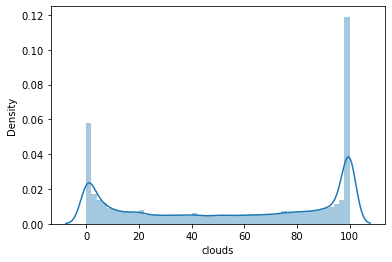

In [28]:
sns.distplot(df_pred["clouds"]);

It can be verified that the average temperature is centered between 275 and 300 Kº (2-27 ºC), reasonable values

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


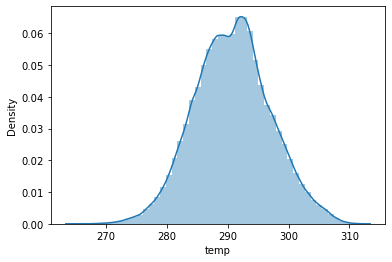

In [29]:
sns.distplot(df_pred["temp"]);

It can be verified that the average wind speed is centered at 3.5 m / s, reasonable values

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


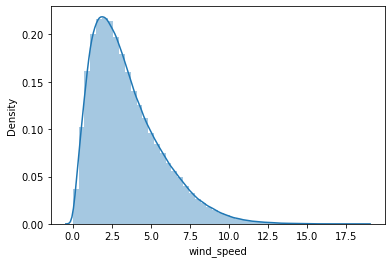

In [30]:
sns.distplot(df_pred["wind_speed"]);

It can be seen that the weather ID contains clear peaks in singular values. For example, 800 means clear sky.

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


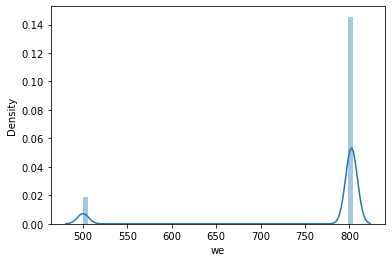

In [31]:
sns.distplot(df_pred["we"]);

It can be seen that there is no clear correlation between the type of weather and the average temperature of a day

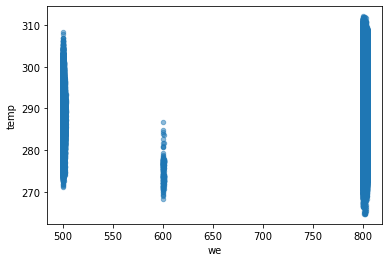

In [32]:
var1 = "we"
var2 = "temp"
data = pd.concat([df_pred[var2], df_pred[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

It can be verified that there is a positive correlation between the thermal sensation and the average temperature of a day

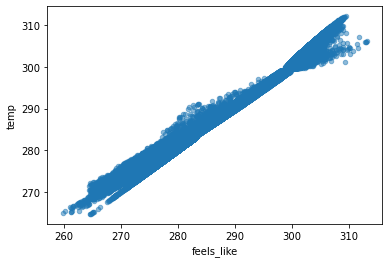

In [33]:
var1 = "feels_like"
var2 = "temp"
data = pd.concat([df_pred[var2], df_pred[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

There does not seem to be a clear correlation between the average wind speed of a day and the average temperature of it

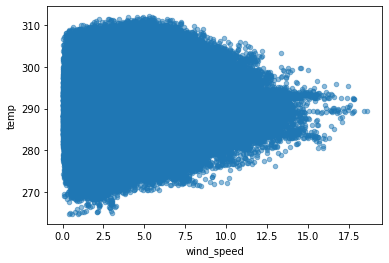

In [34]:
var1 = "wind_speed"
var2 = "temp"
data = pd.concat([df_pred[var2], df_pred[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

The historical dataset of weather predictions is imported with the final processing (where each row corresponds to the mean of the observations of that hour for the two days downloaded)

In [35]:
df_pred = pd.read_csv('./data/Historicos/pred_por_horas.csv', sep=',')

df_pred.head()

,hour,fecha_prediccion,estacion,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,4,2021-04-05,0252D,284.875,284.110,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,5,2021-04-05,0252D,284.910,284.150,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,6,2021-04-05,0252D,285.120,284.400,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,7,2021-04-05,0252D,285.930,285.195,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,8,2021-04-05,0252D,286.500,285.755,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


Kelvin degrees are converted into Cº

In [36]:
df_pred["temp_pred"] = df_pred["temp_pred"] - 273.15
df_pred["feels_like_pred"] = df_pred["feels_like_pred"] - 273.15

df_pred.head()

,hour,fecha_prediccion,estacion,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,4,2021-04-05,0252D,11.725,10.960,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,5,2021-04-05,0252D,11.760,11.000,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,6,2021-04-05,0252D,11.970,11.250,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,7,2021-04-05,0252D,12.780,12.045,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,8,2021-04-05,0252D,13.350,12.605,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


A column is added with the date of the day after the day the data was obtained, since this will be the day for which we want to predict the radiation based on it

In [37]:
import datetime
fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=1)).year), str((pd.to_datetime(f) + datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=1)).day).zfill(2)) for f in df_pred["fecha_prediccion"]]
df_pred.insert(0, "fecha_rad", fechas_atrasadas, True)
df_pred.head()

,fecha_rad,hour,fecha_prediccion,estacion,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,2021-04-06,4,2021-04-05,0252D,11.725,10.960,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,2021-04-06,5,2021-04-05,0252D,11.760,11.000,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,2021-04-06,6,2021-04-05,0252D,11.970,11.250,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,2021-04-06,7,2021-04-05,0252D,12.780,12.045,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,2021-04-06,8,2021-04-05,0252D,13.350,12.605,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


The necessary columns are renamed

In [38]:
df_pred = df_pred.rename(index = str, columns = {"hour": "hora", "estacion": "indicativo"})
df_pred.head()

,fecha_rad,hora,fecha_prediccion,indicativo,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,2021-04-06,4,2021-04-05,0252D,11.725,10.960,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,2021-04-06,5,2021-04-05,0252D,11.760,11.000,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,2021-04-06,6,2021-04-05,0252D,11.970,11.250,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,2021-04-06,7,2021-04-05,0252D,12.780,12.045,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,2021-04-06,8,2021-04-05,0252D,13.350,12.605,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


# Preparation of radiation data from the previous day
<div style = "float:right"><a style="text-decoration:none" href = "#Preparation-of-the-data-for-the-prediction-models">

The dataset of historical radiation data in the AEMET readiation stations is imported 

In [39]:
df_aemet = pd.read_csv('./data/Historicos/rad_aemet_clean.csv', sep=',')

df_aemet.head()

,fecha,hora,estacion,indicativo,GL,UVB,IR
0,2021-04-04,4,A CORUÑA,1387,0.000000,0.000000,266.666667
1,2021-04-04,5,A CORUÑA,1387,8.333333,0.000556,266.666667
2,2021-04-04,6,A CORUÑA,1387,130.555556,0.008056,266.666667
3,2021-04-04,7,A CORUÑA,1387,327.777778,0.027778,266.666667
4,2021-04-04,8,A CORUÑA,1387,525.000000,0.060000,272.222222


In [40]:
df_aemet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45228 entries, 0 to 45227
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   fecha       45228 non-null  object 
 1   hora        45228 non-null  int64  
 2   estacion    45228 non-null  object 
 3   indicativo  45228 non-null  object 
 4   GL          45228 non-null  float64
 5   UVB         45228 non-null  float64
 6   IR          45228 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 2.4+ MB


The necessary column is renamed

In [41]:
df_aemet = df_aemet.rename(columns={'indicativo':'indicativo_rad'})
df_aemet.head()

,fecha,hora,estacion,indicativo_rad,GL,UVB,IR
0,2021-04-04,4,A CORUÑA,1387,0.000000,0.000000,266.666667
1,2021-04-04,5,A CORUÑA,1387,8.333333,0.000556,266.666667
2,2021-04-04,6,A CORUÑA,1387,130.555556,0.008056,266.666667
3,2021-04-04,7,A CORUÑA,1387,327.777778,0.027778,266.666667
4,2021-04-04,8,A CORUÑA,1387,525.000000,0.060000,272.222222


The distribution of radiation values is observed, with many null values belonging to the night hours

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


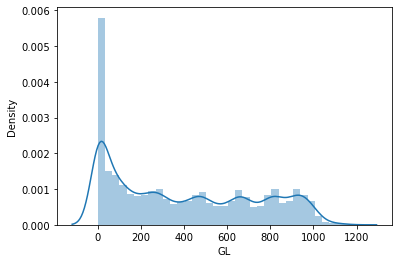

In [42]:
sns.distplot(df_aemet["GL"]);

The distribution of radiation values per hour is clearly observed, with maximums at noon and null values at dawn and dusk.

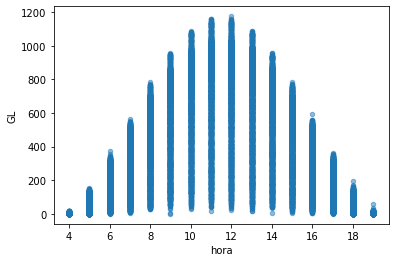

In [43]:
var1 = "hora"
var2 = "GL"
data = pd.concat([df_aemet[var2], df_aemet[var1]], axis=1)
data.plot.scatter(x = var1, y = var2, alpha = 0.5);

A column is added with the date of the day after the data was obtained, since this will be the day for which we want to predict the radiation based on it

In [44]:
import datetime
fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=2)).year), str((pd.to_datetime(f) + datetime.timedelta(days=2)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=2)).day).zfill(2)) for f in df_aemet["fecha"]]
df_aemet.insert(0, "fecha_rad", fechas_atrasadas, True)
df_aemet.head()

,fecha_rad,fecha,hora,estacion,indicativo_rad,GL,UVB,IR
0,2021-04-06,2021-04-04,4,A CORUÑA,1387,0.000000,0.000000,266.666667
1,2021-04-06,2021-04-04,5,A CORUÑA,1387,8.333333,0.000556,266.666667
2,2021-04-06,2021-04-04,6,A CORUÑA,1387,130.555556,0.008056,266.666667
3,2021-04-06,2021-04-04,7,A CORUÑA,1387,327.777778,0.027778,266.666667
4,2021-04-06,2021-04-04,8,A CORUÑA,1387,525.000000,0.060000,272.222222


The necessary columns are renamed

In [45]:
df_aemet = df_aemet.rename(columns={'GL': 'rad_d-1', 'UVB': 'uvb_d-1', 'IR': 'ir_d-1'})
df_aemet.head()

,fecha_rad,fecha,hora,estacion,indicativo_rad,rad_d-1,uvb_d-1,ir_d-1
0,2021-04-06,2021-04-04,4,A CORUÑA,1387,0.000000,0.000000,266.666667
1,2021-04-06,2021-04-04,5,A CORUÑA,1387,8.333333,0.000556,266.666667
2,2021-04-06,2021-04-04,6,A CORUÑA,1387,130.555556,0.008056,266.666667
3,2021-04-06,2021-04-04,7,A CORUÑA,1387,327.777778,0.027778,266.666667
4,2021-04-06,2021-04-04,8,A CORUÑA,1387,525.000000,0.060000,272.222222


# Preparation of historical radiation data
<div style = "float:right"><a style="text-decoration:none" href = "#Preparation-of-the-data-for-the-prediction-models">

CAMS SODA radiation historical data dataframe is loaded

In [46]:
df_soda = pd.read_csv('./data/Historicos/rad_soda_clean.csv', sep=',')

df_soda.head()

,date,ghi,estacion,hora,fecha
0,2021-04-05 04:00:00,0.0000,0252D,4,2021-04-05
1,2021-04-05 05:00:00,6.3289,0252D,5,2021-04-05
2,2021-04-05 06:00:00,120.0964,0252D,6,2021-04-05
3,2021-04-05 07:00:00,303.6657,0252D,7,2021-04-05
4,2021-04-05 08:00:00,484.0124,0252D,8,2021-04-05


The necessary columns are renamed

In [47]:
df_soda = df_soda.rename(index = str, columns = {"estacion": "indicativo", "fecha": "fecha_rad"})

In [48]:
df_soda.shape

(345184, 5)

In [49]:
df_soda.head()

,date,ghi,indicativo,hora,fecha_rad
0,2021-04-05 04:00:00,0.0000,0252D,4,2021-04-05
1,2021-04-05 05:00:00,6.3289,0252D,5,2021-04-05
2,2021-04-05 06:00:00,120.0964,0252D,6,2021-04-05
3,2021-04-05 07:00:00,303.6657,0252D,7,2021-04-05
4,2021-04-05 08:00:00,484.0124,0252D,8,2021-04-05


Unnecessary column is removed

In [50]:
df_soda.drop(['date'], axis=1, inplace = True)

The radiation target variable is also the hourly radiation of two days before data collection, one of the inputs of the models. To do this, a new dataset is created with the radiation values, associated with 2 days after the registered value (day for which we want to make a prediction based on these values)

In [51]:
import datetime

df_rad_2 = pd.DataFrame(columns = ["indicativo", "hora", "rad_d-2"])
df_rad_2["indicativo"] = df_soda["indicativo"]
df_rad_2["hora"] = df_soda["hora"]
df_rad_2["rad_d-2"] = df_soda["ghi"]

fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=3)).year), str((pd.to_datetime(f) + datetime.timedelta(days=3)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=3)).day).zfill(2)) for f in df_soda["fecha_rad"]]
df_rad_2.insert(0, "fecha_rad", fechas_atrasadas, True)

df_rad_2.head()

,fecha_rad,indicativo,hora,rad_d-2
0,2021-04-08,0252D,4,0.0000
1,2021-04-08,0252D,5,6.3289
2,2021-04-08,0252D,6,120.0964
3,2021-04-08,0252D,7,303.6657
4,2021-04-08,0252D,8,484.0124


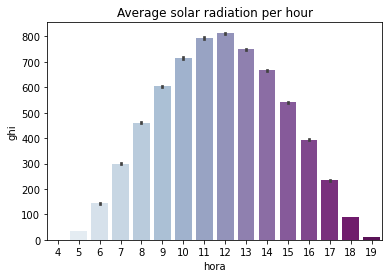

In [52]:
ax = plt.axes()
sns.barplot(x = "hora", y = 'ghi', data = df_soda, palette = "BuPu", ax = ax)
ax.set_title('Average solar radiation per hour')
plt.show()

# Join of datasets
<div style = "float:right"><a style="text-decoration:none" href = "#Preparation-of-the-data-for-the-prediction-models">

The datasets to merge are:
   - ``df_soda``: Objective variable nº1. Global radiation on horizontal ground in W/m² for each hour and weather station.
   - ``df_objetivos``: Objective variable nº2. Average temperature in Cº.
   - ``df_clima``: Climate data for the 5 days prior to the day the prediction is made (day before the day to be predicted).
   - ``df_pred``: Weather predictions for the next 48 hours after the prediction is made (day before the day to be predicted).
   - ``df_aemet``: Hourly radiation data in W/m² of the day before the prediction is made (day before the day to be predicted) for each hour and weather station.
   - ``df_rad_2``: Hourly radiation data in W/m² of two days before the forecast is made (day before the day to be predicted) for each hour and weather station.

In [53]:
print("Radiation target variable")
print(df_soda.head())

print("Ambient temperature target variable")
print(df_objetivos.head())

print("Climatic data of the previous 5 days")
print(df_clima.head())

print("Weather predictions for the day the prediction is made and the next")
print(df_pred.head())

print("Hourly radiation data for the previous day")
print(df_aemet.head())

print("Hourly radiation data from two days before")
print(df_rad_2.head())

Radiation target variable
        ghi indicativo  hora   fecha_rad
0    0.0000      0252D     4  2021-04-05
1    6.3289      0252D     5  2021-04-05
2  120.0964      0252D     6  2021-04-05
3  303.6657      0252D     7  2021-04-05
4  484.0124      0252D     8  2021-04-05
Ambient temperature target variable
    fecha_rad  hora indicativo  temp_objetivo
0  2021-04-04     4      0252D          11.15
1  2021-04-04     5      0252D          11.44
2  2021-04-04     6      0252D          11.26
3  2021-04-04     7      0252D          11.84
4  2021-04-04     8      0252D          13.26
Climatic data of the previous 5 days
    fecha_rad  hora fecha_prediccion indicativo  temp_d-1  feels_like_d-1  \
0  2021-04-06     4       2021-04-05      0252D     11.15            9.41   
1  2021-04-06     5       2021-04-05      0252D     11.44            9.42   
2  2021-04-06     6       2021-04-05      0252D     11.26           10.73   
3  2021-04-06     7       2021-04-05      0252D     11.84           11.

Unnecessary columns are removed

In [54]:
df_clima.drop(['fecha_prediccion'], axis = 1, inplace = True)

In [55]:
df_pred.drop(['fecha_prediccion'], axis = 1, inplace = True)

In [56]:
df_aemet.drop(['fecha'], axis = 1, inplace = True)
df_aemet.drop(['estacion'], axis = 1, inplace = True)

In [57]:
print("Radiation target variable")
print(df_soda.shape)

print("Ambient temperature target variable")
print(df_objetivos.shape)

print("Climatic data of the previous 5 days")
print(df_clima.shape)

print("Weather predictions for the day the prediction is made and the next")
print(df_pred.shape)

print("Hourly radiation data for the previous day")
print(df_aemet.shape)

print("Hourly radiation data from two days before")
print(df_rad_2.shape)

Radiation target variable
(345184, 4)
Ambient temperature target variable
(374016, 4)
Climatic data of the previous 5 days
(374016, 61)
Weather predictions for the day the prediction is made and the next
(382480, 16)
Hourly radiation data for the previous day
(45228, 6)
Hourly radiation data from two days before
(345184, 4)


The different dataframes are joined by the column ``date_rad`` (date of radiation to be predicted), the ``hora`` and the ``indicativo``/``indicativo_rad`` of the meteorological/radiation station.

In [58]:
df_total = pd.merge(df_clima, df_pred, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred
0,2021-04-06,4,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.689019,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.689019,800,11.52,9.78,1026,68,278.98,42,9767.26843,1.12,338,1.18,802,0201D,41.5875,2.54,11.725,10.960,1014.0,77.0,280.500,0.000,31.5,10000.0,2.565,168.5,3.325,0.0,801.5
1,2021-04-06,5,0252D,11.44,9.42,1014,93,283.50,0,10000.0,3.09,290,4.689019,800,11.51,10.06,1012,81,281.52,0,10000.0,1.54,320,4.689019,800,10.56,9.24,1014,81,280.59,0,10000.0,1.03,0,4.689019,800,8.15,5.85,1020,81,278.24,0,10000.0,1.70,288,1.760000,800,11.44,9.71,1026,67,278.69,50,9767.26843,1.02,336,1.10,800,0201D,41.5875,2.54,11.760,11.000,1014.0,77.0,280.550,0.000,34.0,10000.0,2.770,21.5,3.700,0.0,801.5
2,2021-04-06,6,0252D,11.26,10.73,1015,87,282.33,0,10000.0,0.51,0,4.689019,800,12.03,11.19,1012,76,281.09,0,10000.0,0.51,0,4.689019,800,11.89,10.07,1014,71,279.96,0,10000.0,1.54,300,4.689019,800,8.27,6.32,1020,87,279.39,0,10000.0,1.54,280,4.689019,800,11.46,9.81,1026,68,278.92,41,9767.26843,0.97,324,1.07,802,0201D,41.5875,2.54,11.970,11.250,1014.5,77.5,280.785,0.115,33.5,10000.0,2.950,40.0,3.905,0.0,801.5
3,2021-04-06,7,0252D,11.84,11.46,1016,87,282.90,0,10000.0,0.51,0,4.689019,800,14.07,13.10,1012,71,282.05,0,10000.0,1.03,0,4.689019,800,12.63,10.28,1015,71,280.67,0,10000.0,2.53,31,2.920000,800,10.97,9.63,1021,70,278.87,0,10000.0,0.51,0,4.689019,800,12.89,11.65,1026,64,279.40,47,9767.26843,0.54,329,0.85,802,0201D,41.5875,2.54,12.780,12.045,1014.5,74.0,280.950,0.465,32.5,10000.0,2.825,68.0,3.715,0.0,801.5
4,2021-04-06,8,0252D,13.26,13.02,1016,82,283.41,0,10000.0,0.51,0,4.689019,800,15.71,14.59,1013,55,279.85,0,10000.0,0.51,0,4.689019,800,15.38,14.36,1015,58,280.32,0,10000.0,0.51,0,4.689019,800,13.67,12.10,1021,54,277.69,0,10000.0,0.51,150,4.689019,800,14.37,13.27,1026,58,279.37,54,9767.26843,0.32,121,0.67,803,0201D,41.5875,2.54,13.350,12.605,1014.5,71.5,280.835,1.250,34.0,10000.0,2.170,96.5,2.890,0.0,801.5


In [59]:
df_total.shape

(359024, 74)

In [60]:
df_total = pd.merge(df_total, df_aemet, how = "inner", on = ["fecha_rad", "hora", "indicativo_rad"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1
0,2021-04-06,4,0252D,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,11.60,9.58,1014,76,280.67,0,10000.0,2.06,290,4.689019,800,9.13,6.91,1020,75,278.09,0,10000.0,1.54,310,4.689019,800,11.52,9.78,1026,68,278.98,42,9767.26843,1.12,338,1.18,802,0201D,41.587500,2.540000,11.725,10.960,1014.0,77.0,280.500,0.0,31.5,10000.0,2.565,168.5,3.325,0.0,801.5,0.0,0.0,336.966076
1,2021-04-06,4,0076,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.689019,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.689019,801,12.33,9.09,1013,62,278.42,20,10000.0,3.09,330,4.689019,801,10.03,5.31,1020,71,278.17,0,10000.0,5.14,330,4.689019,800,13.52,12.24,1026,69,281.10,74,9767.26843,1.14,59,1.24,803,0201D,41.292778,2.070000,13.970,13.250,1013.5,70.0,281.420,0.0,42.0,10000.0,4.070,147.0,5.060,0.0,801.5,0.0,0.0,336.966076
2,2021-04-06,4,0200E,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.689019,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.689019,801,12.57,9.38,1014,62,278.64,20,10000.0,3.09,330,4.689019,801,10.26,5.58,1020,71,278.39,0,10000.0,5.14,330,4.689019,800,11.10,9.29,1026,63,277.48,61,9767.26843,0.79,25,0.98,803,0201D,41.418333,2.124167,11.915,10.825,1014.0,63.5,279.235,0.0,42.5,10000.0,2.285,145.0,3.165,0.0,802.0,0.0,0.0,336.966076
3,2021-04-06,4,0201D,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.689019,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.689019,801,12.61,9.43,1014,62,278.68,20,10000.0,3.09,330,4.689019,801,10.29,5.62,1020,71,278.42,0,10000.0,5.14,330,4.689019,800,13.13,11.87,1026,66,280.08,60,9767.26843,0.77,37,1.00,803,0201D,41.390556,2.200000,13.885,13.035,1013.5,65.5,280.420,0.0,43.5,10000.0,2.880,147.5,3.745,0.0,802.0,0.0,0.0,336.966076
4,2021-04-06,4,0149X,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.689019,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.689019,800,9.28,6.77,1014,76,278.42,0,10000.0,2.06,290,4.689019,800,8.10,5.69,1020,75,277.09,0,10000.0,1.54,310,4.689019,800,8.92,7.04,1026,68,276.49,27,9767.26843,0.62,346,0.68,802,0201D,41.720000,1.840278,9.715,8.730,1014.5,70.0,276.985,0.0,44.0,10000.0,1.550,298.0,1.690,0.0,802.0,0.0,0.0,336.966076


In [61]:
df_total.shape

(347226, 77)

In [62]:
df_total = pd.merge(df_total, df_rad_2, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.689019,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.689019,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,12.53,9.62,1015,53,276.37,70,9767.26843,2.06,12,2.33,803,0201D,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,336.966076,0.0
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.689019,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.689019,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.689019,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.689019,801,14.44,11.15,1015,58,279.44,69,9767.26843,3.48,47,3.68,803,0201D,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,336.966076,0.0
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.689019,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.689019,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.689019,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.689019,801,12.19,8.87,1015,47,274.37,60,9767.26843,2.17,34,2.37,803,0201D,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,336.966076,0.0
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.689019,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.689019,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.689019,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.689019,801,14.08,11.07,1015,52,277.53,64,9767.26843,2.51,40,2.73,803,0201D,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,336.966076,0.0
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.689019,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.689019,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.689019,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.689019,800,9.95,7.33,1016,58,275.23,63,9767.26843,1.37,3,1.44,803,0201D,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,336.966076,0.0


In [63]:
df_total.shape

(295284, 78)

In [64]:
df_total = pd.merge(df_total, df_soda, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.689019,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.689019,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,12.53,9.62,1015,53,276.37,70,9767.26843,2.06,12,2.33,803,0201D,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,336.966076,0.0,0.0
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.689019,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.689019,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.689019,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.689019,801,14.44,11.15,1015,58,279.44,69,9767.26843,3.48,47,3.68,803,0201D,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,336.966076,0.0,0.0
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.689019,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.689019,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.689019,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.689019,801,12.19,8.87,1015,47,274.37,60,9767.26843,2.17,34,2.37,803,0201D,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,336.966076,0.0,0.0
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.689019,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.689019,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.689019,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.689019,801,14.08,11.07,1015,52,277.53,64,9767.26843,2.51,40,2.73,803,0201D,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,336.966076,0.0,0.0
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.689019,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.689019,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.689019,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.689019,800,9.95,7.33,1016,58,275.23,63,9767.26843,1.37,3,1.44,803,0201D,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,336.966076,0.0,0.0


In [65]:
df_total.shape

(272079, 79)

In [66]:
df_total = pd.merge(df_total, df_objetivos, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,indicativo_rad,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.689019,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.689019,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,12.53,9.62,1015,53,276.37,70,9767.26843,2.06,12,2.33,803,0201D,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.04
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.689019,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.689019,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.689019,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.689019,801,14.44,11.15,1015,58,279.44,69,9767.26843,3.48,47,3.68,803,0201D,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.28
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.689019,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.689019,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.689019,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.689019,801,12.19,8.87,1015,47,274.37,60,9767.26843,2.17,34,2.37,803,0201D,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.18
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.689019,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.689019,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.689019,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.689019,801,14.08,11.07,1015,52,277.53,64,9767.26843,2.51,40,2.73,803,0201D,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.23
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.689019,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.689019,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.689019,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.689019,800,9.95,7.33,1016,58,275.23,63,9767.26843,1.37,3,1.44,803,0201D,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,336.966076,0.0,0.0,6.46


Unnecessary column is removed

In [67]:
df_total.drop(['indicativo_rad'], axis = 1, inplace = True)

In [68]:
df_total.shape

(252112, 79)

In [69]:
print("The maximum number of data that can be in one day is {}".format(len(df_estaciones["indicativo"])*16))

The maximum number of data that can be in one day is 4592


It is observed that there are dates that have less data than others. In some cases it will be due to the number of NAs they contained, in others it will be due to a failure when downloading the data (there are days that, due to testing or having the computer doing other things, I have had download errors)

In [70]:
df_total['fecha_rad'].value_counts()

2021-05-23    4592
2021-05-25    4592
2021-05-26    4592
2021-06-09    4592
2021-05-27    4588
2021-04-22    4576
2021-05-14    4576
2021-04-19    4569
2021-05-20    4567
2021-06-10    4566
2021-06-16    4554
2021-05-04    4544
2021-04-25    4544
2021-04-27    4544
2021-04-30    4544
2021-05-05    4544
2021-05-03    4544
2021-05-02    4540
2021-04-23    4540
2021-04-26    4537
2021-06-05    4536
2021-06-14    4536
2021-05-28    4532
2021-06-08    4529
2021-06-03    4529
2021-06-02    4523
2021-06-04    4522
2021-05-21    4518
2021-05-30    4516
2021-06-06    4515
2021-06-12    4507
2021-05-18    4496
2021-05-19    4491
2021-05-07    4468
2021-05-24    4448
2021-06-24    4432
2021-06-28    4423
2021-06-19    4411
2021-06-01    4408
2021-05-22    4406
2021-06-17    4401
2021-06-15    4385
2021-05-06    4384
2021-05-29    3629
2021-05-15    3456
2021-05-17    3392
2021-06-22    3078
2021-04-18    2160
2021-04-12    2160
2021-04-13    2160
2021-04-08    2160
2021-04-20    2160
2021-04-10  

It is observed that there are stations that tend to have data less frequently than others

In [71]:
df_total['indicativo'].value_counts()

0255B    1152
0076     1152
1437O    1152
0252D    1152
1387E    1152
0200E    1152
0149X    1152
1473A    1152
0372C    1152
1387     1152
1475X    1152
1183X    1152
0367     1152
0370B    1152
1351     1152
1393     1152
1400     1152
0002I    1152
1428     1152
0201D    1152
0324A    1152
0229I    1152
0016A    1137
2444     1120
1059X    1120
2867     1120
1083L    1120
1078I    1120
1690B    1120
1109     1120
1700X    1120
2444C    1120
1110     1120
1505     1120
1690A    1120
2811A    1120
2331     1120
2870     1120
1495     1120
1111     1120
1484C    1120
1484     1120
1159     1120
2235U    1120
2298     1120
2946X    1120
2916A    1120
2491C    1120
2465     1118
2150H    1118
2462     1118
2465A    1118
2661B    1114
2630X    1114
2661     1114
1208A    1104
1210X    1104
2401     1104
1283U    1104
1208H    1104
2117D    1104
1207U    1104
2400E    1104
1221D    1104
2030     1104
2374X    1104
1208     1104
1212E    1104
1024E    1097
1050J    1097
1002Y    1097
1014  

It is observed that there are some hours that tend to have data less frequently than others

In [72]:
df_total['hora'].value_counts()

16    15786
15    15779
7     15772
6     15772
8     15765
14    15763
17    15759
13    15758
19    15757
4     15755
9     15752
18    15751
11    15750
10    15738
12    15733
5     15722
Name: hora, dtype: int64

It is found that some of the different variables correlate with each other, such as thermal sensation and ambient temperature

In [98]:
df_total.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.689019,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.689019,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,12.53,9.62,1015,53,276.37,70,9767.26843,2.06,12,2.33,803,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.04
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.689019,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.689019,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.689019,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.689019,801,14.44,11.15,1015,58,279.44,69,9767.26843,3.48,47,3.68,803,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.28
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.689019,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.689019,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.689019,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.689019,801,12.19,8.87,1015,47,274.37,60,9767.26843,2.17,34,2.37,803,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.18
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.689019,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.689019,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.689019,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.689019,801,14.08,11.07,1015,52,277.53,64,9767.26843,2.51,40,2.73,803,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.23
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.689019,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.689019,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.689019,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.689019,800,9.95,7.33,1016,58,275.23,63,9767.26843,1.37,3,1.44,803,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,336.966076,0.0,0.0,6.46


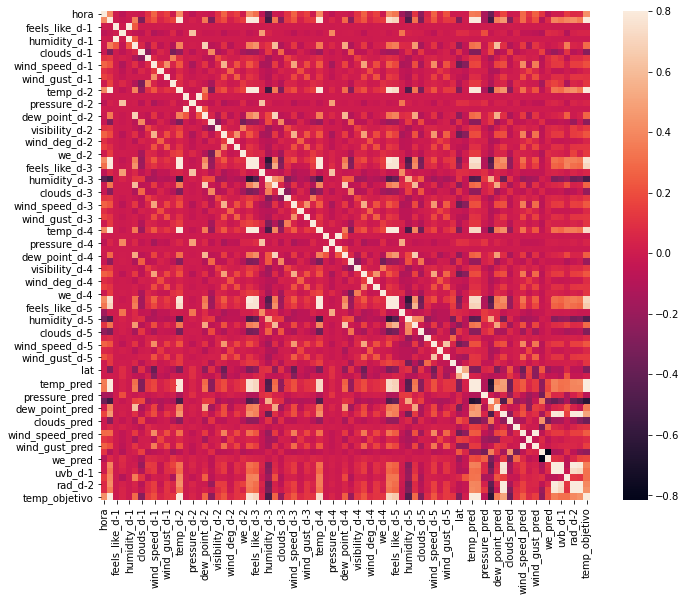

In [99]:
corrmat = df_total.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = .8, square = True);

Therefore, **the dimensionality of the dataset will be reduced** before training the models

The correlation between the radiation target variable and those that will be used for the prediction is checked. The most significant is the UV radiation prediction for the day to be predicted

In [100]:
corr = abs(df_total.corr())
corr[['ghi']].sort_values(by = 'ghi',ascending = False).style.background_gradient()

,ghi
ghi,1.000000
uvi_pred,0.869423
rad_d-2,0.819787
rad_d-1,0.783835
uvb_d-1,0.715554
humidity_pred,0.486990
temp_objetivo,0.437414
temp_pred,0.403048
feels_like_pred,0.385743
temp_d-1,0.356995


The correlation between the objective variable of room temperature and those that will be used for the prediction is checked. The most significant is the temperature prediction for the day to be predicted

In [101]:
corr = abs(df_total.corr())
corr[['temp_objetivo']].sort_values(by = 'temp_objetivo',ascending = False).style.background_gradient()

,temp_objetivo
temp_objetivo,1.000000
temp_pred,0.902896
feels_like_pred,0.896139
temp_d-1,0.835631
temp_d-2,0.797537
temp_d-3,0.763713
temp_d-4,0.740585
temp_d-5,0.711412
feels_like_d-3,0.706959
feels_like_d-5,0.657335


### NAs management

In [102]:
total = df_total.isnull().sum().sort_values(ascending = False)
percent = (df_total.isnull().sum()/df_total.isnull().count()).sort_values(ascending = False)
missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
temp_objetivo,0,0.0
humidity_d-3,0,0.0
wind_speed_d-2,0,0.0
wind_deg_d-2,0,0.0
wind_gust_d-2,0,0.0
we_d-2,0,0.0
temp_d-3,0,0.0
feels_like_d-3,0,0.0
pressure_d-3,0,0.0
dew_point_d-3,0,0.0


There's no NAs

In [103]:
df_total.describe()

,hora,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
count,252112.000000,252112.000000,2.521120e+05,252112.000000,2.521120e+05,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,2.521120e+05,252112.000000,2.521120e+05,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,2.521120e+05,252112.000000,2.521120e+05,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000,252112.000000
mean,11.501162,18.123210,-1.434635e+13,1014.391794,-1.463377e+14,283.072693,35.144555,9756.487861,3.454581,162.177945,4.722615,777.240588,18.003432,-1.435066e+13,1014.358051,-1.463377e+14,282.944453,35.234745,9753.973652,3.454748,163.484027,4.723056,776.354259,17.844758,15.609357,1014.113323,63.485471,282.935176,36.070409,9745.839584,3.431930,163.344168,4.713516,774.788487,17.780608,-1.435280e+13,1013.702319,-1.463377e+14,283.016642,36.608198,9737.340377,3.441267,165.628411,4.732498,772.359447,17.735603,15.321189,1014.670829,61.403614,282.383388,45.010491,9806.649104,3.485585,174.195326,4.589376,773.284243,39.913051,-4.100812,17.869614,17.222803,1016.448354,60.508068,281.996214,2.931072,55.848813,9907.959183,3.287898,174.352478,4.301257,0.123455,766.830444,398.066622,0.067401,337.838602,403.099210,403.843436,18.443891
std,4.609732,5.994425,3.601701e+15,9.579256,3.673841e+16,4.977173,34.718672,994.347624,2.385777,112.220382,1.786822,83.824748,6.001710,3.602782e+15,9.806537,3.673841e+16,4.981523,34.532767,1001.535334,2.380811,112.307653,1.797312,84.837301,5.959599,6.408257,9.899741,21.026804,4.862791,34.834484,1021.306223,2.367345,111.887101,1.785167,87.307439,5.902042,3.603320e+15,10.356861,3.673841e+16,4.963362,34.890692,1043.967772,2.387702,112.615914,1.846865,90.791208,6.136316,6.646601,8.647454,19.943269,4.997768,37.998058,579.868797,2.350185,108.224226,2.463768,89.326746,3.502754,4.036434,5.987065,6.175891,4.490867,18.726318,4.324195,2.926697,30.556576,562.614730,1.865224,87.508081,2.330174,0.203892,75.538465,333.227444,0.064174,30.303170,325.838234,326.369771,5.888360
min,4.000000,-5.000000,-9.082920e+17,682.000000,-9.223372e+18,0.000000,0.000000,50.000000,0.010000,0.000000,0.000000,300.000000,-5.000000,-9.082920e+17,682.000000,-9.223372e+18,0.000000,0.000000,50.000000,0.010000,0.000000,0.000000,300.000000,-4.730000,-14.240000,682.000000,4.000000,250.210000,0.000000,50.000000,0.010000,0.000000,0.000000,300.000000,-5.000000,-9.082920e+17,682.000000,-9.223372

Column names are converted to strings

In [104]:
df_total.columns = [str(i) for i in df_total.columns]

It is investigated whether the different variables to be used follow a normal distribution

In [11]:
%store -r df_total

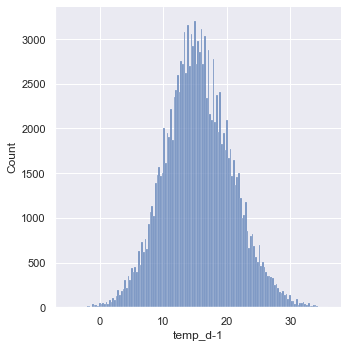

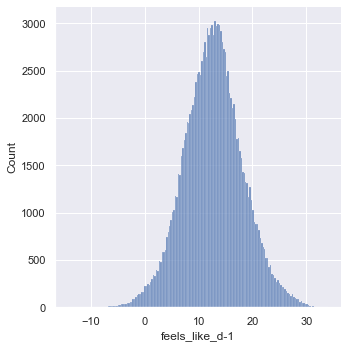

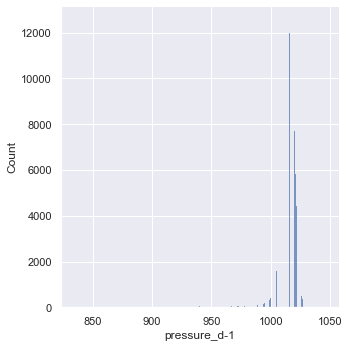

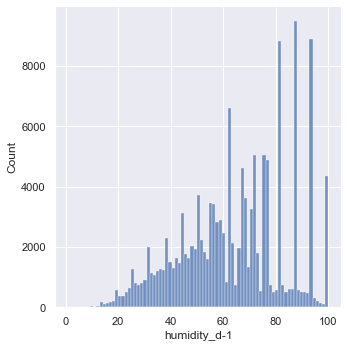

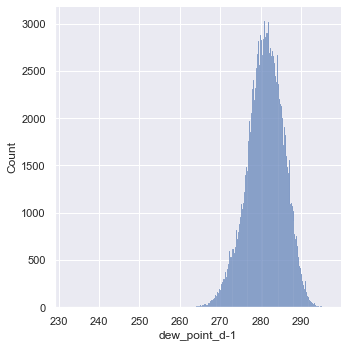

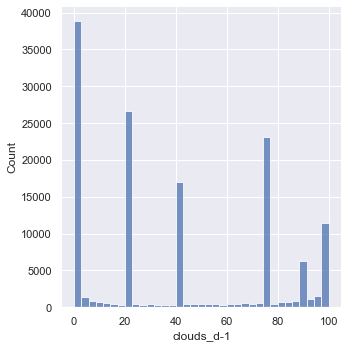

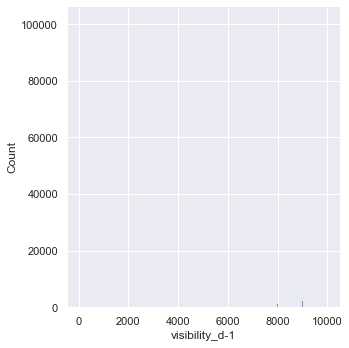

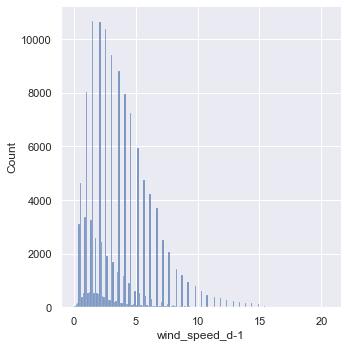

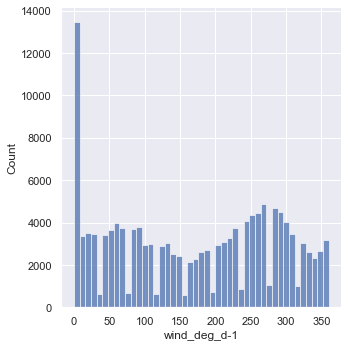

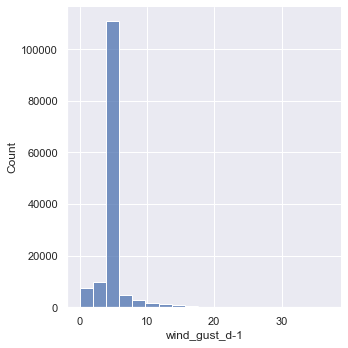

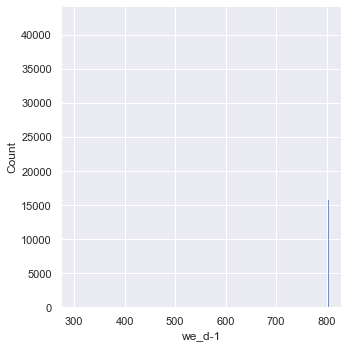

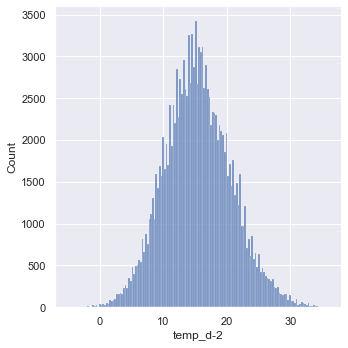

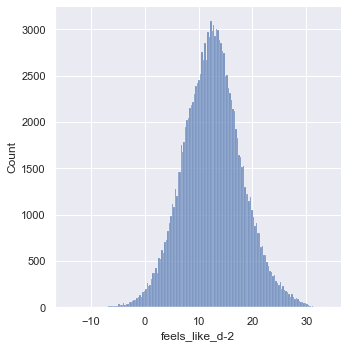

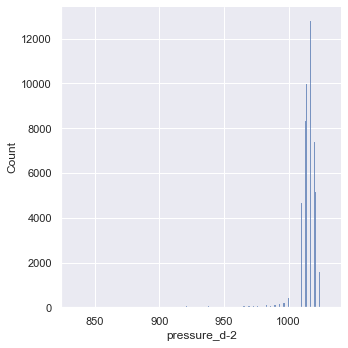

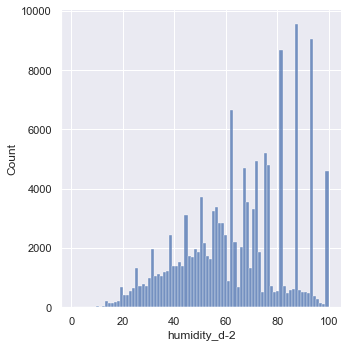

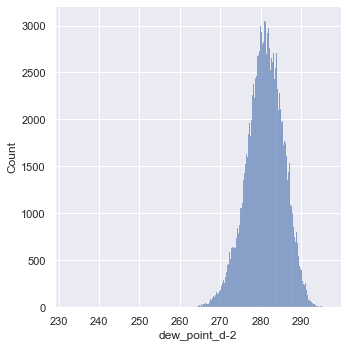

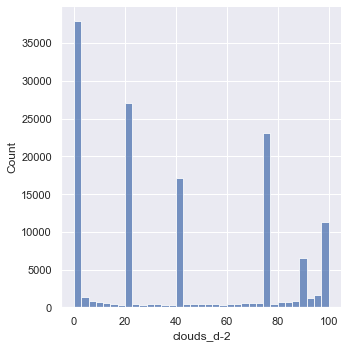

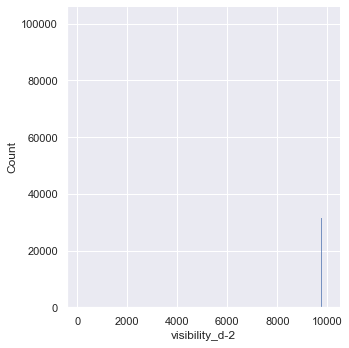

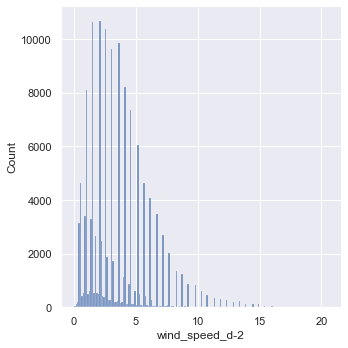

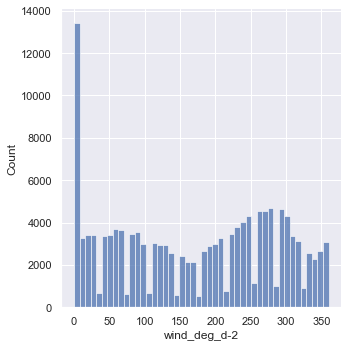

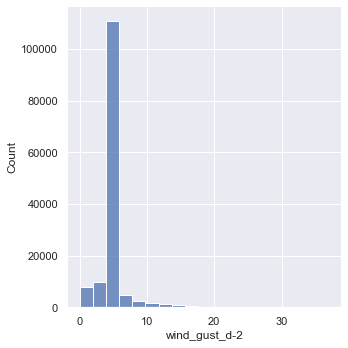

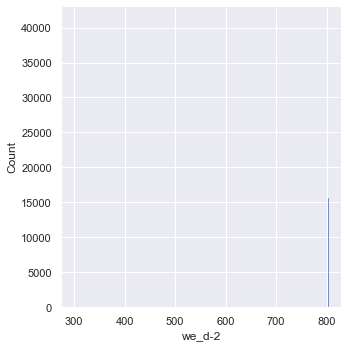

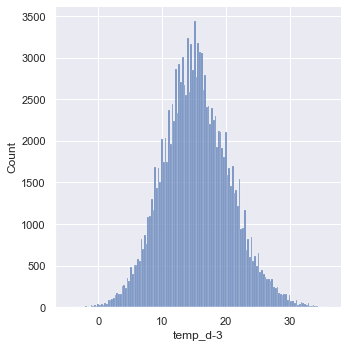

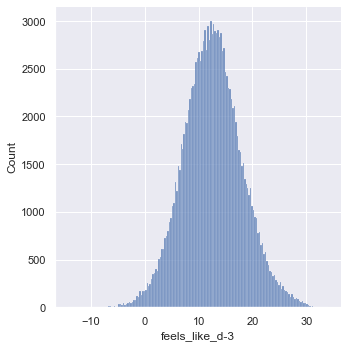

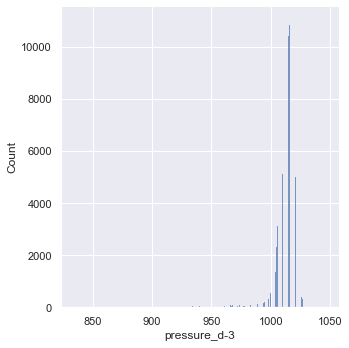

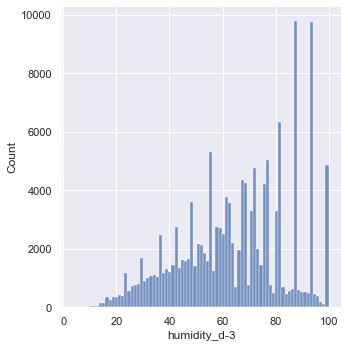

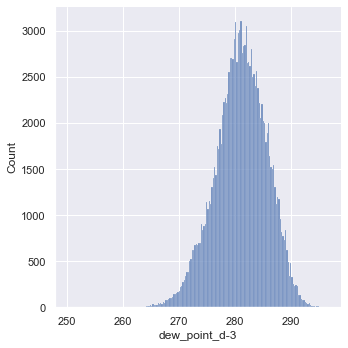

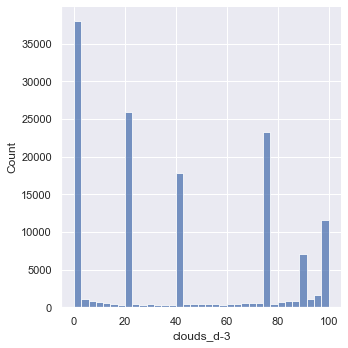

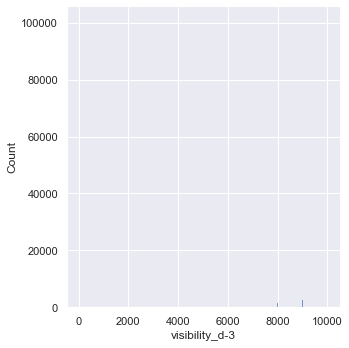

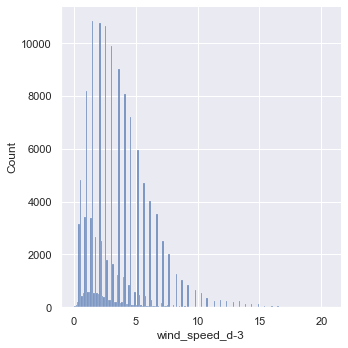

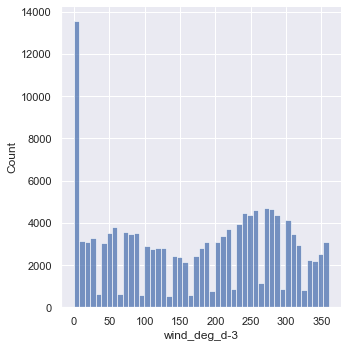

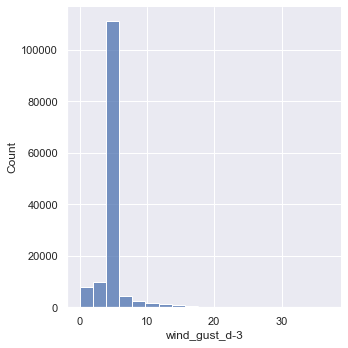

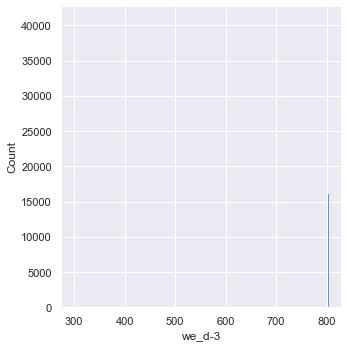

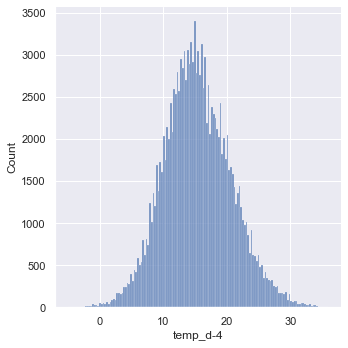

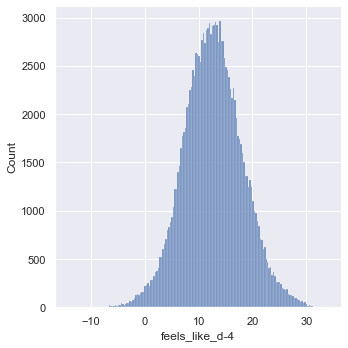

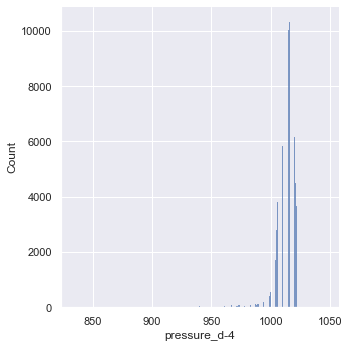

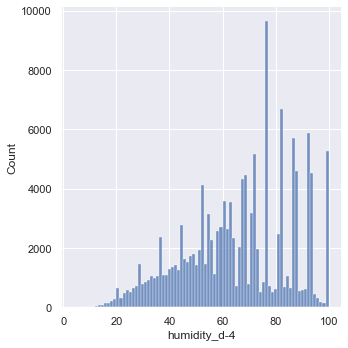

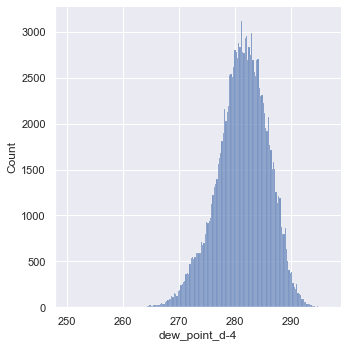

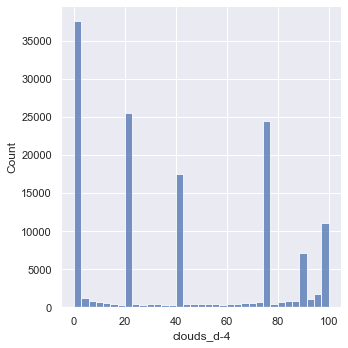

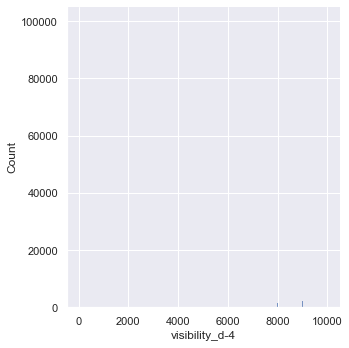

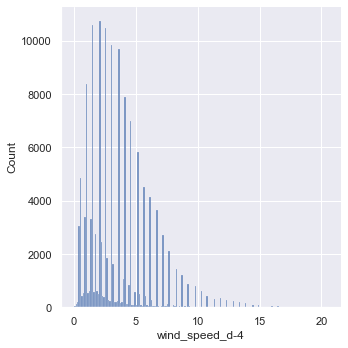

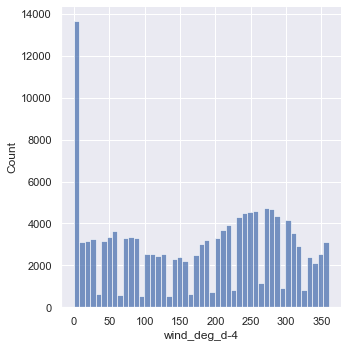

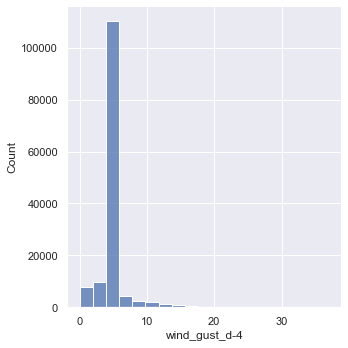

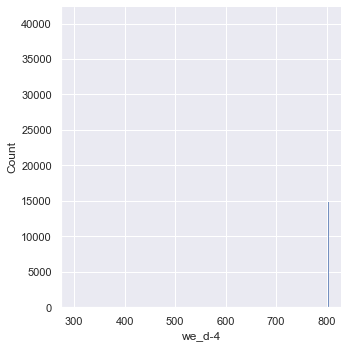

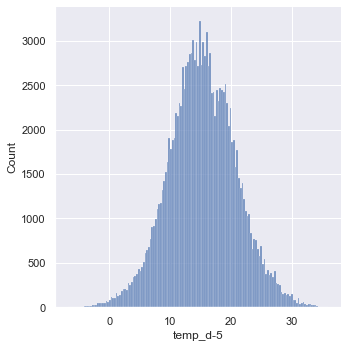

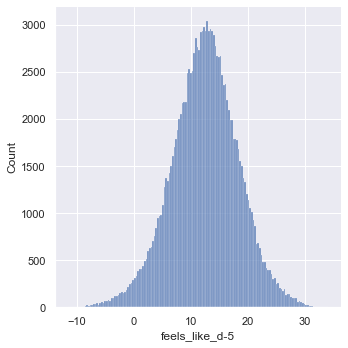

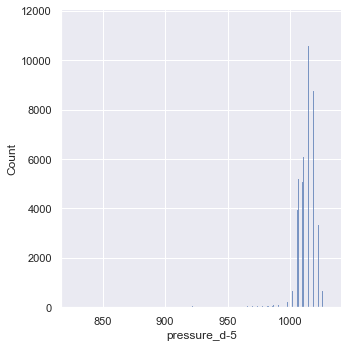

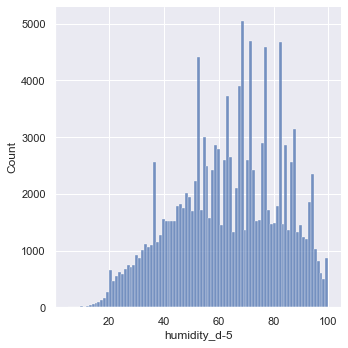

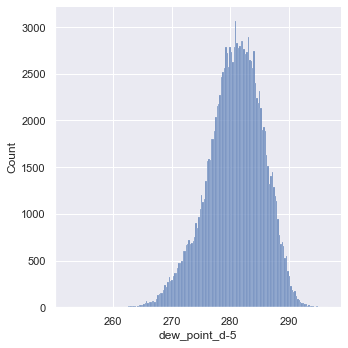

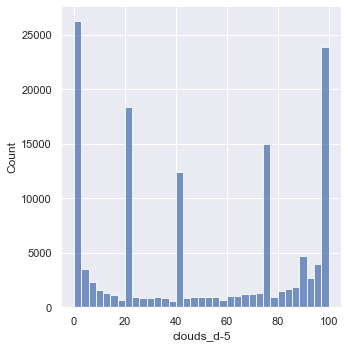

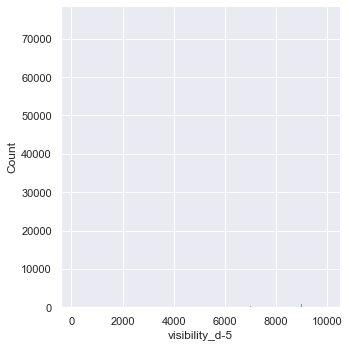

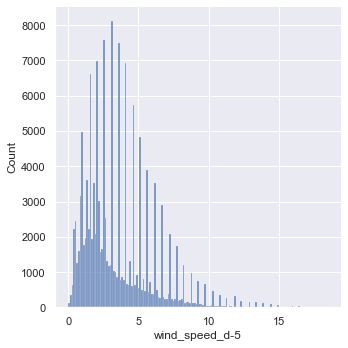

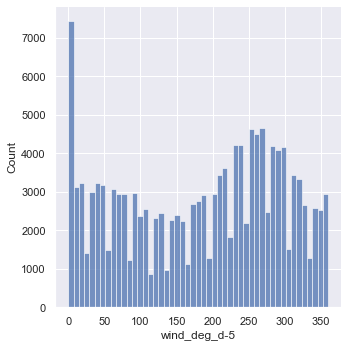

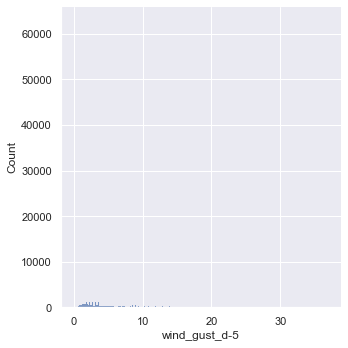

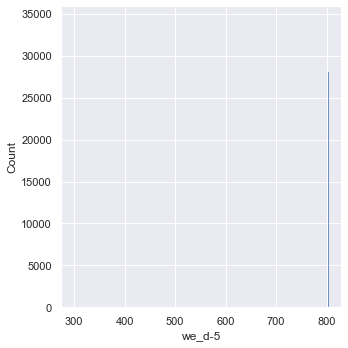

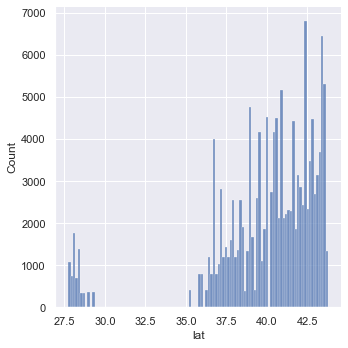

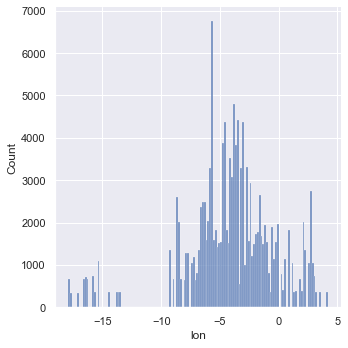

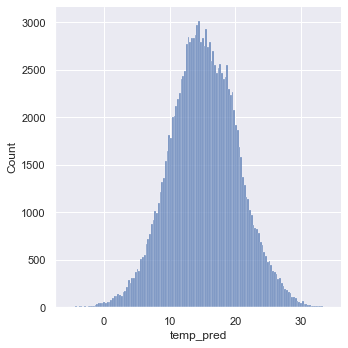

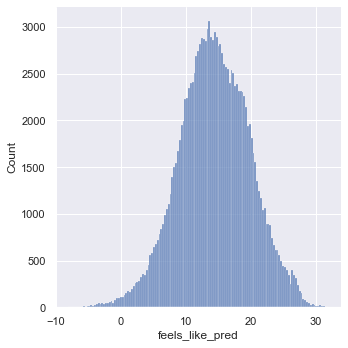

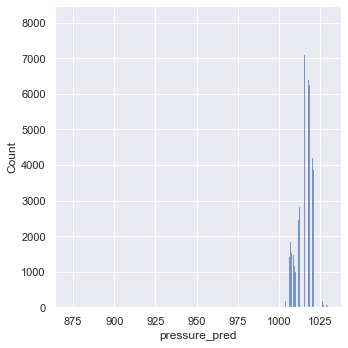

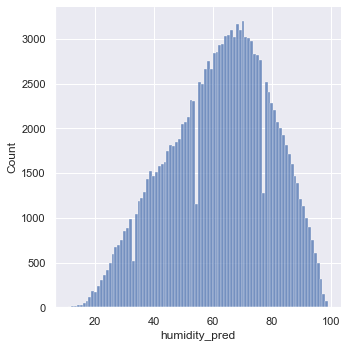

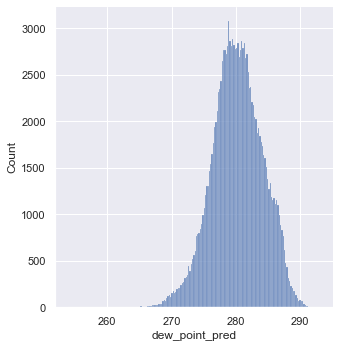

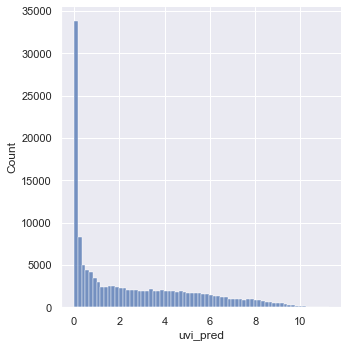

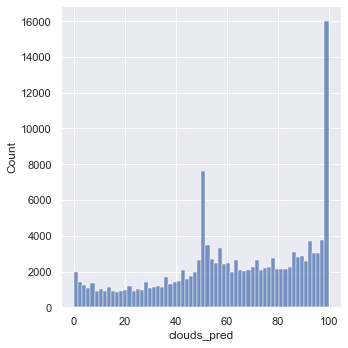

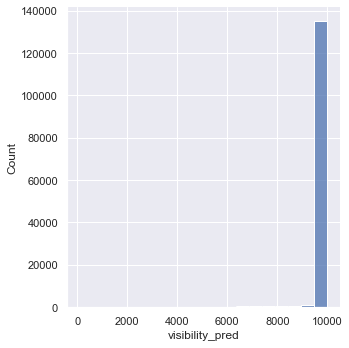

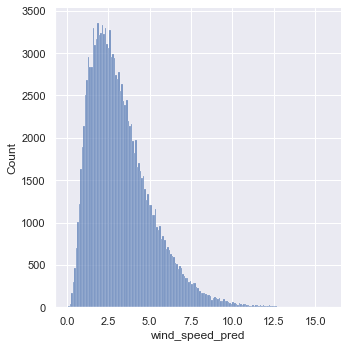

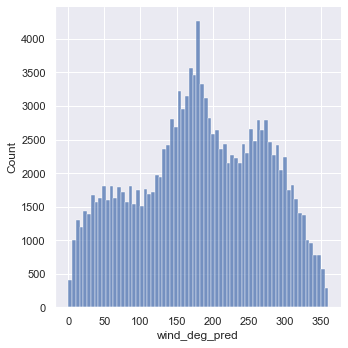

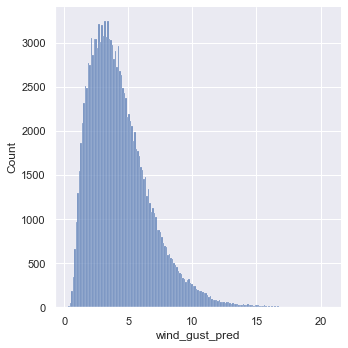

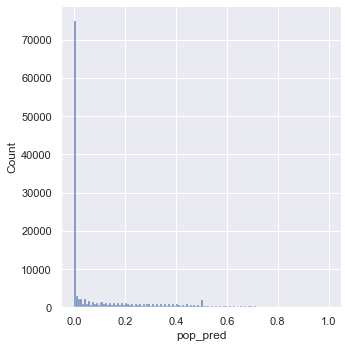

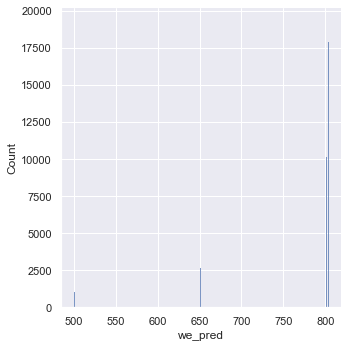

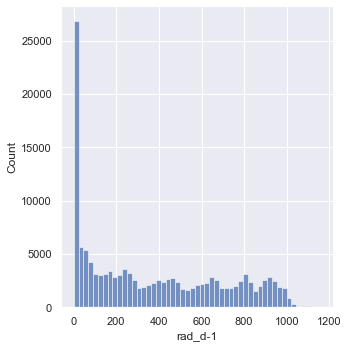

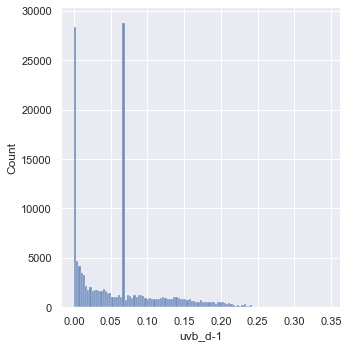

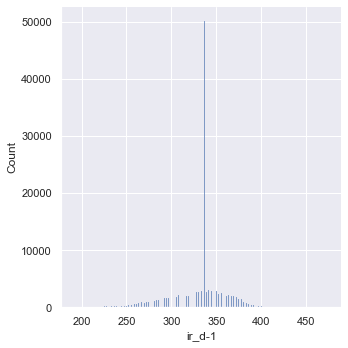

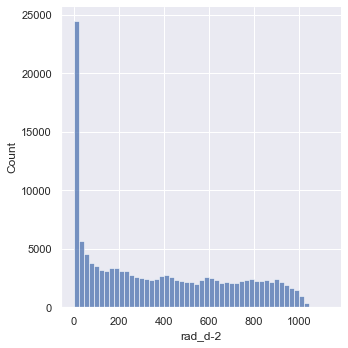

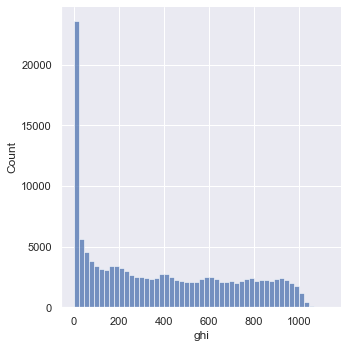

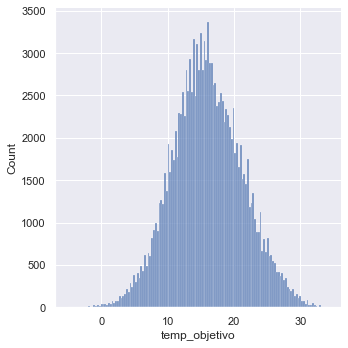

In [12]:
for i in range(3, len(df_total.columns)):
        sns.set()
        cols = list(df_total.columns)[i]
        sns.displot(df_total[cols][:140000])
        plt.show();

In [13]:
df_total.shape

(252112, 79)

It is proven that it is not, so a process of **standardization** of the data will also be necessary.

Detail of some example components:

<AxesSubplot:xlabel='pressure_d-2', ylabel='Count'>

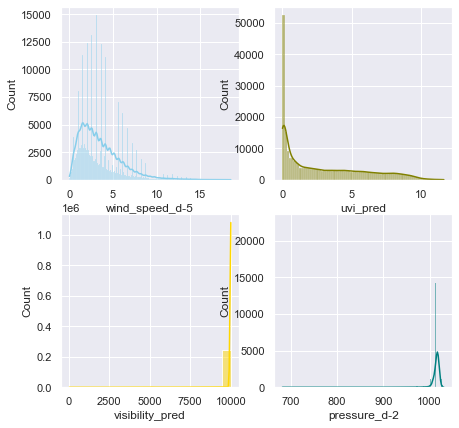

In [14]:
sns.set(style="darkgrid")
df = df_total

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

sns.histplot(data = df, x = "wind_speed_d-5", kde = True, color = "skyblue", ax = axs[0, 0])
sns.histplot(data = df, x = "uvi_pred", kde = True, color = "olive", ax = axs[0, 1])
sns.histplot(data = df, x = "visibility_pred", kde = True, color = "gold", ax = axs[1, 0])
sns.histplot(data = df, x = "pressure_d-2", kde = True, color = "teal", ax = axs[1, 1])

In [15]:
from scipy import stats

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


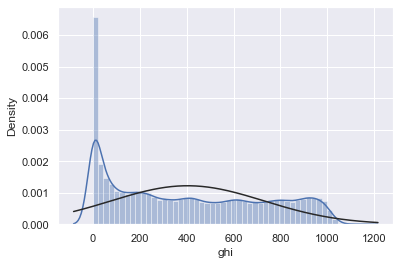

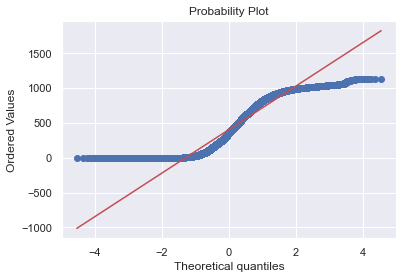

In [16]:
sns.distplot(df_total['ghi'], fit = stats.norm);
fig = plt.figure()
res = stats.probplot(df_total['ghi'], plot = plt)

The cross relationship between the variables that most influence the value of solar radiation is shown below by means of a “pairs” graph or pairplot

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


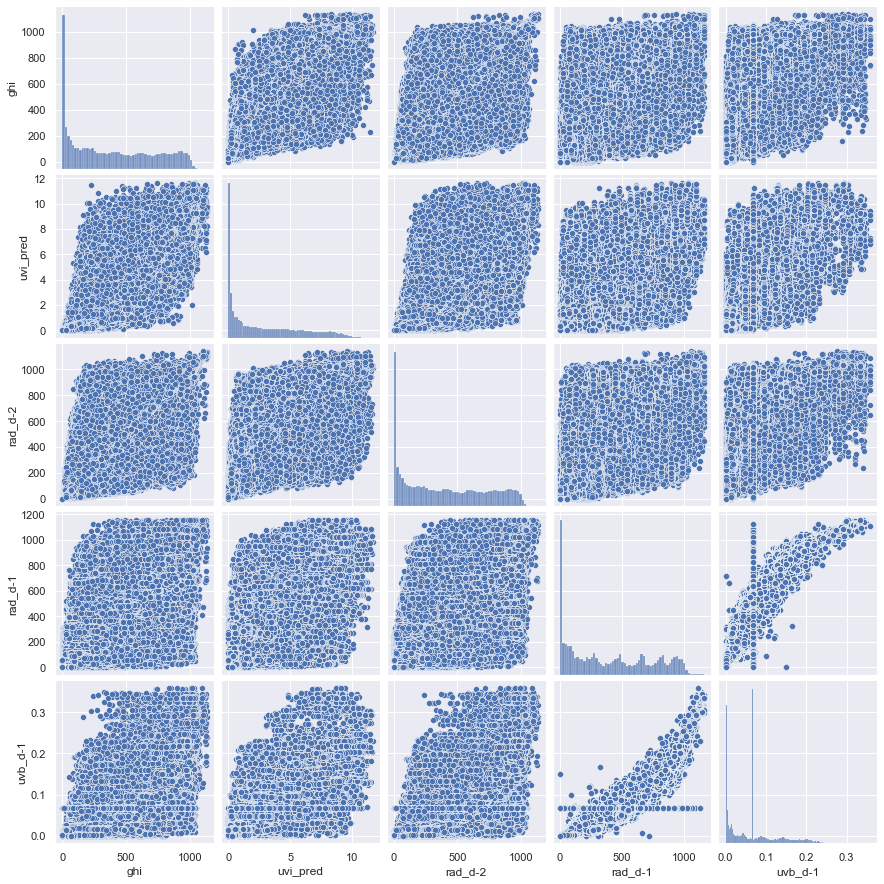

In [17]:
sns.set()
cols = ['ghi', "uvi_pred", "rad_d-2", "rad_d-1", "uvb_d-1"]
sns.pairplot(df_total[cols], size = 2.5)
plt.show();

The cross relationship between the variables that most influence the value of ambient temperature is shown below by means of a “pairs” graph or pairplot

/home/dsc/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


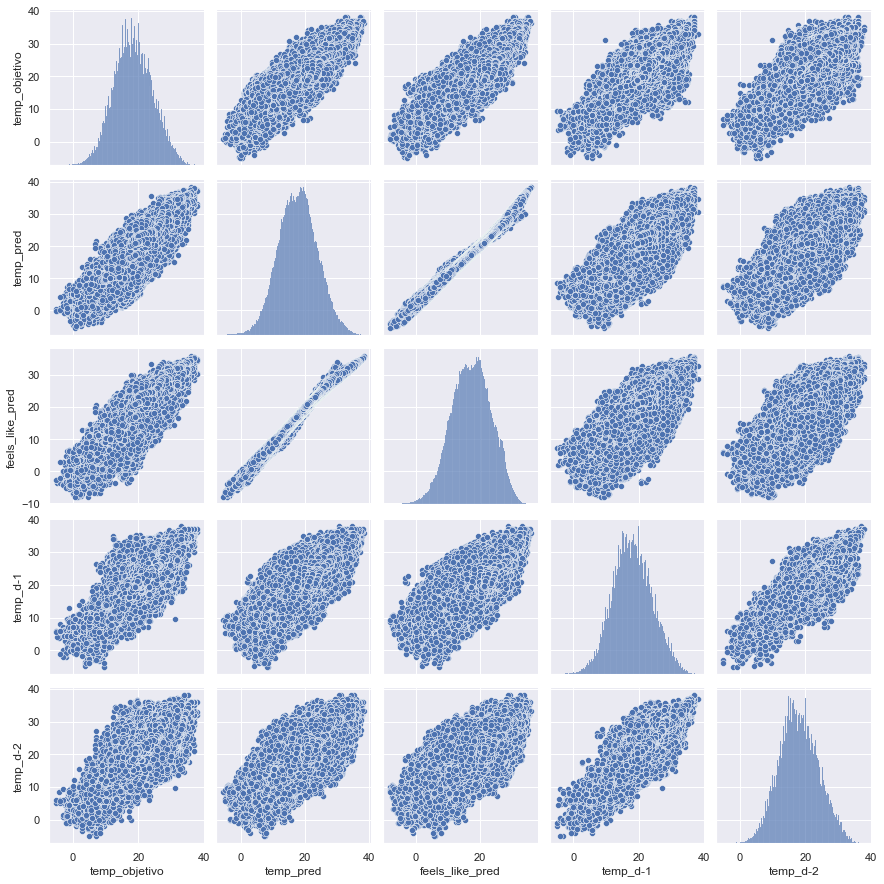

In [18]:
sns.set()
cols = ['temp_objetivo', "temp_pred", "feels_like_pred", "temp_d-1", "temp_d-2"]
sns.pairplot(df_total[cols], size = 2.5)
plt.show();

# Final function
<div style = "float:right"><a style="text-decoration:none" href = "#Preparation-of-the-data-for-the-prediction-models">

In [19]:
def merge_datasets(df_estaciones, df_estaciones_rad, df_clima, df_pred, df_aemet, df_soda):
    
    ## WEATHER ##
    print("Processing WEATHER")
    
    # The column of dates of the day to be predicted is added to the climatological dataset
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=1)).year), str((pd.to_datetime(f) + datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=1)).day).zfill(2)) for f in df_clima["fecha_prediccion"]]
    df_clima.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    # Columns are renamed and temperatures are converted to degrees Cº
    df_clima = df_clima.rename(index = str, columns = {"hour": "hora", "estacion": "indicativo"})
    
    df_clima["temp_d-1"] = df_clima["temp_d-1"] - 273.15
    df_clima["temp_d-2"] = df_clima["temp_d-2"] - 273.15
    df_clima["temp_d-3"] = df_clima["temp_d-3"] - 273.15
    df_clima["temp_d-4"] = df_clima["temp_d-4"] - 273.15
    df_clima["temp_d-5"] = df_clima["temp_d-5"] - 273.15
    df_clima["feels_like_d-1"] = df_clima["feels_like_d-1"] - 273.15
    df_clima["feels_like_d-2"] = df_clima["feels_like_d-2"] - 273.15
    df_clima["feels_like_d-3"] = df_clima["feels_like_d-3"] - 273.15
    df_clima["feels_like_d-4"] = df_clima["feels_like_d-4"] - 273.15
    df_clima["feels_like_d-5"] = df_clima["feels_like_d-5"] - 273.15
    
    # The new dataframe is created with the target temperature column
    df_objetivos = pd.DataFrame(columns = ["hora", "indicativo", "temp_objetivo"])
    df_objetivos["hora"] = df_clima["hora"]
    df_objetivos["indicativo"] = df_clima["indicativo"]
    df_objetivos["temp_objetivo"] = df_clima["temp_d-1"]

    # The column of dates of the day to be predicted is added to the climatological dataset
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) - datetime.timedelta(days=1)).year), str((pd.to_datetime(f) - datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) - datetime.timedelta(days=1)).day).zfill(2)) for f in df_clima["fecha_prediccion"]]
    df_objetivos.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    # Unnecessary columns are removed
    df_clima.drop(['fecha_prediccion'], axis = 1, inplace = True)
    
    # The column of indicative codes of the nearest radiation stations is added   
    df_clima["indicativo_rad"] = np.nan
    df_clima["lat"] = np.nan
    df_clima["lon"] = np.nan

    for i, fila in df_clima.iterrows():

        j = list(df_estaciones["indicativo"]).index(fila["indicativo"])
        lat = conversor_coordenadas(str(df_estaciones["latitud"].loc[j]))
        lon = conversor_coordenadas(str(df_estaciones["longitud"].loc[j]))
        
        df_clima.loc[i,"lat"] = lat
        df_clima.loc[i,"lon"] = lon
    
        dist = 99999999999999999999

        # For each row, the nearest radiation station is obtained
        for k in range(0, len(df_estaciones_rad["indicativo"])): 
            lat_est = conversor_coordenadas(str(df_estaciones_rad["latitud"].loc[k]))
            lon_est = conversor_coordenadas(str(df_estaciones_rad["longitud"].loc[k]))

            distancia_prueba = distancia(lat, lon, lat_est, lon_est)
            if(distancia_prueba < dist):
                dist = distancia_prueba
                df_clima.loc[i, "indicativo_rad"] = df_estaciones_rad.loc[k, "indicativo"]

    ## PREDICTION ##  
    print("Processing PREDICTION")
    
    # Temperature variables are converted to degrees Cº       
    df_pred["temp_pred"] = df_pred["temp_pred"] - 273.15
    df_pred["feels_like_pred"] = df_pred["feels_like_pred"] - 273.15
    
    # The column of dates of the day to be predicted is added to the dataset of climatological predictions
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=1)).year), str((pd.to_datetime(f) + datetime.timedelta(days=1)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=1)).day).zfill(2)) for f in df_pred["fecha_prediccion"]]
    df_pred.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    # Columns are renamed and unnecessary ones are removed
    df_pred = df_pred.rename(index = str, columns = {"hour": "hora", "estacion": "indicativo"})
    df_pred.drop(['fecha_prediccion'], axis = 1, inplace = True)
    
    ## PREVIOUS DAY RADIATION ##
    print("Processing PREVIOUS DAY RADIATION")
    
    # The column of dates of the day to be predicted is added to the AEMET radiation dataset
    df_aemet = df_aemet.rename(columns={'indicativo':'indicativo_rad'})
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=2)).year), str((pd.to_datetime(f) + datetime.timedelta(days=2)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=2)).day).zfill(2)) for f in df_aemet["fecha"]]
    df_aemet.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    # Columns are renamed
    df_aemet = df_aemet.rename(columns={'GL': 'rad_d-1', 'UVB': 'uvb_d-1', 'IR': 'ir_d-1'})
    
    # Unnecessary columns are removed
    df_aemet.drop(['fecha'], axis = 1, inplace = True)
    df_aemet.drop(['estacion'], axis = 1, inplace = True)
    
    ## RADIATION ##
    print("Processing RADIATION")
    
    # Columns are renamed and unnecessary ones are removed
    df_soda = df_soda.rename(index = str, columns = {"estacion": "indicativo", "fecha": "fecha_rad"})
    df_soda.drop(['date'], axis=1, inplace = True)
    
    # A dataset is created that contains the radiation variable from three days before the predicted one
    df_rad_2 = pd.DataFrame(columns = ["indicativo", "hora", "rad_d-2"])
    df_rad_2["indicativo"] = df_soda["indicativo"]
    df_rad_2["hora"] = df_soda["hora"]
    df_rad_2["rad_d-2"] = df_soda["ghi"]
    
    # The column of dates of the day to be predicted is added to the radiation dataset of three days before
    fechas_atrasadas = ["{}-{}-{}".format(str((pd.to_datetime(f) + datetime.timedelta(days=3)).year), str((pd.to_datetime(f) + datetime.timedelta(days=3)).month).zfill(2), str((pd.to_datetime(f) + datetime.timedelta(days=3)).day).zfill(2)) for f in df_soda["fecha_rad"]]
    df_rad_2.insert(0, "fecha_rad", fechas_atrasadas, True)
    
    ## MERGE ##
    print("Processing MERGE")
    
    # Datasets are joined
    df_total = pd.merge(df_clima, df_pred, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
    df_total = pd.merge(df_total, df_aemet, how = "inner", on = ["fecha_rad", "hora", "indicativo_rad"])
    df_total = pd.merge(df_total, df_rad_2, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
    df_total = pd.merge(df_total, df_soda, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
    df_total = pd.merge(df_total, df_objetivos, how = "inner", on = ["fecha_rad", "hora", "indicativo"])
       
    df_total.drop(['indicativo_rad'], axis = 1, inplace = True)
    
    df_total.columns = [str(i) for i in df_total.columns]

    # The new dataframe is saved
    nombre = './data/Historicos/datos_modelo.csv'
    df_total.to_csv(nombre, index = False)
    
    return df_total
    

In [15]:
import pandas as pd
import numpy as np
import random
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pickle as pk
pd.options.display.max_columns = None
pd.options.display.max_rows = None


hora_ini = 4
hora_fin = 20


def distancia(lat1, lon1, lat2, lon2, distancia = "euclidea"):
    
    if(distancia == "euclidea"):
        dist = math.sqrt((lat1 - lat2)**2 + (lon1 -lon2)**2)
    
    elif(distancia == "manhattan"):
        dist = abs(lat1 - lat2) + abs(lon1 -lon2)
  
    return dist 

def conversor_coordenadas(coord):
    # If coord is latitude, north of the equator is always positive
    # If coord is longitude, west of the Meridian 0º are negative
    
    D = int(coord[0:2])
    M = float(coord[2:4])
    S = float(coord[4:6])
    
    #GMS to GD
    DD = float((D) + (M/60) + (S/3600))
        
    if(coord[6] == "S" or coord[6] == "W"):
            DD = -DD
            
    return DD


# The weather station dataset is imported
df_estaciones = pd.read_csv(directorio + 'data/estaciones.csv')

# The radiation station dataset is imported
df_estaciones_rad = pd.read_csv(directorio + 'data/estaciones_rad.csv')
df_estaciones_rad.dropna(inplace = True)
df_estaciones_rad.reset_index(drop = True, inplace = True)

# The climate data dataset is imported
df_clima = pd.read_csv('./data/Historicos/clima_por_horas.csv', sep=',')

# The climate prediction data dataset is imported
df_pred = pd.read_csv('./data/Historicos/pred_por_horas.csv', sep=',')

# AEMET radiation dataset is imported
df_aemet = pd.read_csv('./data/Historicos/rad_aemet_clean.csv', sep=',')

# The target radiation dataset is imported
df_soda = pd.read_csv('./data/Historicos/rad_soda_clean.csv', sep=',')

df_total = merge_datasets(df_estaciones, df_estaciones_rad, df_clima, df_pred, df_aemet, df_soda)
df_total.head()

Processing WEATHER
Processing PREDICTION
Processing PREVIOUS DAY RADIATION
Processing RADIATION
Processing MERGE


,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.689019,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.689019,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.689019,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.689019,800,12.53,9.62,1015,53,276.37,70,9767.26843,2.06,12,2.33,803,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.04
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.689019,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.689019,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.689019,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.689019,801,14.44,11.15,1015,58,279.44,69,9767.26843,3.48,47,3.68,803,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.28
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.689019,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.689019,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.689019,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.689019,801,12.19,8.87,1015,47,274.37,60,9767.26843,2.17,34,2.37,803,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.18
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.689019,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.689019,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.689019,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.689019,801,14.08,11.07,1015,52,277.53,64,9767.26843,2.51,40,2.73,803,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,336.966076,0.0,0.0,8.23
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.689019,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.689019,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.689019,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.689019,800,9.95,7.33,1016,58,275.23,63,9767.26843,1.37,3,1.44,803,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,336.966076,0.0,0.0,6.46


In [16]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252112 entries, 0 to 252111
Data columns (total 79 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fecha_rad        252112 non-null  object 
 1   hora             252112 non-null  int64  
 2   indicativo       252112 non-null  object 
 3   temp_d-1         252112 non-null  float64
 4   feels_like_d-1   252112 non-null  float64
 5   pressure_d-1     252112 non-null  int64  
 6   humidity_d-1     252112 non-null  int64  
 7   dew_point_d-1    252112 non-null  float64
 8   clouds_d-1       252112 non-null  int64  
 9   visibility_d-1   252112 non-null  float64
 10  wind_speed_d-1   252112 non-null  float64
 11  wind_deg_d-1     252112 non-null  int64  
 12  wind_gust_d-1    252112 non-null  float64
 13  we_d-1           252112 non-null  int64  
 14  temp_d-2         252112 non-null  float64
 15  feels_like_d-2   252112 non-null  float64
 16  pressure_d-2     252112 non-null  int6

### Sanity check

In [17]:
print('Different years: ', pd.to_datetime([year for year in pd.to_datetime(df_total['fecha_rad'])]).year.nunique())
print('Different months:', pd.to_datetime([year for year in pd.to_datetime(df_total['fecha_rad'])]).month.nunique())
print('There must be 31 different days:', pd.to_datetime([year for year in pd.to_datetime(df_total['fecha_rad'])]).day.nunique())


print('There should only be different times within the filtering hours: ', df_total['hora'].nunique())

Different years:  1
Different months: 3
There must be 31 different days: 30
There should only be different times within the filtering hours:  16
